In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
import pandas as pd
import ast

# TO DO: Repeat with high number of repeats (sub-samples) - e.g. 100 rather than 5.

# TO DO: Add uncertainty into model trajectories (i.e 95% confidence interval? Could be developed based on Mason's work.)

# TO DO: Plot bar graphs for each error type (MSE, MAE, BIC, Log-Likelihood, etc.) for calibration & validation, for each of the 5 models.

# TO DO: Which models predict co-utilisation in continuous process?

# TO DO: Remove fixed K_Z_c and K_Z_d in both enzyme models

# TO DO: Check handling of dilution rate with 1 or 2 feeds

In [3]:
# Define parameter estimation functions

def get_bounds(params, fitType, **kwargs):
    LB = kwargs.get('LB', 0.001)
    UB = kwargs.get('UB', 1)
    n_feeds = params['n_feeds']
    n_substrates = params['n_substrates']
    enzyme_induction = params['enzyme_induction']
    N_params = get_N_params(enzyme_induction, fitType)
    if fitType == 'calibration':
        if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
            bounds = [(LB,UB)]*N_params
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
            bounds = [(LB,UB)]*N_params
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
            bounds = [(LB,UB)]*N_params
        return bounds
    elif fitType == 'validation':
        if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
            bounds = [(LB,UB)]*N_params
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
            bounds = [(LB,UB)]*N_params
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
            bounds = [(LB,UB)]*N_params
        return bounds
    else:    
        return ValueError('Invalid fitType')

def get_N_params(enzyme_induction, typeOfTest):
    if typeOfTest == 'validation':
        if enzyme_induction == 'Kompala':
            N_params = 3
        elif enzyme_induction == True:
            N_params = 2
        elif enzyme_induction == False:
            N_params = 1 
    elif typeOfTest == 'calibration':
        if enzyme_induction == 'Kompala':
            N_params = 12
        elif enzyme_induction == True:
            N_params = 12
        elif enzyme_induction == False:
            N_params = 8
    return N_params

def calibration_function(x, *args):
    params = args[0].copy()
    exp_data = args[1].copy()
    errorType = args[2]
    n_feeds = params['n_feeds']
    n_substrates = params['n_substrates']
    growth_model = params['growth_model']
    enzyme_induction = params['enzyme_induction']
    times = exp_data['Time (h)']
    if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
        params['mu_max1'], params['mu_max2'] = x[0], x[1]
        params['Yx1'], params['Yx2'] = x[2], x[3]
        params['K_s1'], params['K_s2'] = x[4], x[5]
        params['K_Z_c'], params['K_Z_S'] = x[6], x[7]
        params['K_Z_d'] = x[8]
        params['K_I'] = x[9]
        params['X0'] = x[10]
        params['Z0'] = x[11]

    elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
        params['mu_max1'], params['mu_max2'] = x[0], x[1]
        params['Yx1'], params['Yx2'] = x[2], x[3]
        params['K_s1'], params['K_s2'] = x[4], x[5]
        params['K_I'] = x[6]
        params['X0'] = x[7]

    elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
        params['mu_max1'], params['mu_max2'] = x[0], x[1]
        params['Yx1'], params['Yx2'] = x[2], x[3]
        params['K_s1'], params['K_s2'] = x[4], x[5]
        params['K_Z_c'], params['K_Z_S'] = x[6], x[7]
        params['K_Z_d'] = x[8]
        params['X0'] = x[9]
        params['Z1'], params['Z2'] = x[10], x[11]
    return calc_total_error(params, times, exp_data, errorType) 

def validation_function(x, *args):
    params = args[0].copy()
    exp_data = args[1].copy()
    errorType = args[2]
    n_feeds = params['n_feeds']
    n_substrates = params['n_substrates']
    growth_model = params['growth_model']
    enzyme_induction = params['enzyme_induction']
    
    times = exp_data['Time (h)']
    if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
        params['X0'] = x[0]
        params['Z0'] = x[1]
    elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
        params['X0'] = x[0]
    elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
        params['X0'] = x[0]
        params['Z1'], params['Z2'] = x[1], x[2]
    return calc_total_error(params, times, exp_data, errorType)

def get_param_name_order(params, fitType ):
    n_feeds = params['n_feeds']
    n_substrates = params['n_substrates']
    enzyme_induction = params['enzyme_induction']
    if fitType == 'calibration':
        if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
            param_list_order = ['mu_max1', 'mu_max2', 'Yx1', 'Yx2', 'K_s1', 'K_s2', 'K_Z_c', 'K_Z_S', 'K_Z_d', 'K_I', 'X0', 'Z0']
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
            param_list_order = ['mu_max1', 'mu_max2', 'Yx1', 'Yx2', 'K_s1', 'K_s2', 'K_I', 'X0']
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
            param_list_order = ['mu_max1', 'mu_max2', 'Yx1', 'Yx2', 'K_s1', 'K_s2', 'K_Z_c', 'K_Z_S', 'K_Z_d', 'X0', 'Z1', 'Z2']
    elif fitType == 'validation':
        if n_feeds == 1 and n_substrates == 2 and enzyme_induction == True:
            param_list_order = ['X0', 'Z0']
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == False:
            param_list_order = ['X0']
        elif n_feeds == 1 and n_substrates == 2 and enzyme_induction == 'Kompala':
            param_list_order = ['X0','Z1', 'Z2']
    else: 
        return ValueError('Invalid fitType')
    return param_list_order

In [48]:
# Define ODEs     
def plantODE(y, t, plant_parameters):
    # NB Monod Growth Model used
    # Assign parameters
    n_substrates = plant_parameters.get("n_substrates", 1)
    n_feeds = plant_parameters.get("n_feeds", 1)
    enzyme_induction = plant_parameters.get("enzyme_induction", False)
    growth_model = plant_parameters.get("growth_model", "Monod")
    if n_substrates == 1:
            mu_max = plant_parameters["mu_max"]        # Maximum specific growth rate (1/hr)             
            K_s = plant_parameters["K_s"]              # Half saturation constant for glucose, unit: g/l 
            Yx = plant_parameters["Yx"]              # Yield coefficient of biomass on glucose (g biomass/g substrate)
            S_in = plant_parameters["S_in"]
    if n_substrates == 2:
            mu_max1 = plant_parameters["mu_max1"]        # Maximum specific growth rate (1/hr) on glucose
            mu_max2 = plant_parameters["mu_max2"]        # Maximum specific growth rate (1/hr) on xylose
            K_s1 = plant_parameters["K_s1"]              # Half saturation constant for glucose, unit: g/l
            K_s2 = plant_parameters["K_s2"]              # Half saturation constant for xylose, unit: g/l

            Yx1 = plant_parameters["Yx1"]                # Yield coefficient of biomass on glucose (g biomass/g substrate)
            Yx2 = plant_parameters["Yx2"]                # Yield coefficient of biomass on xylose (g biomass/g substrate)
            S_in1 = plant_parameters["S_in1"]
            S_in2 = plant_parameters["S_in2"]

            # K_Z = plant_parameters["K_Z"]              # Half saturation constant for xylose metabolism dependent on enzyme concentration, unit: g/l
    if enzyme_induction == True or enzyme_induction == 'Kompala':
            K_Z_d = plant_parameters["K_Z_d"]            # Degradation constant of enzyme, unit: 1/hour
            K_Z_c = plant_parameters["K_Z_c"]            # Constant of enzyme production, unit: 1/hour
            K_Z_S = plant_parameters["K_Z_S"]            # Half saturation constant for enzyme concentration, units: g/l ('True') or units/g biomass ('Kompala')
    if enzyme_induction == False:
            K_I = plant_parameters["K_I"]                # Cross-Inhibition constant for xylose in presence of glucose, unit: g/l
            
    if n_feeds == 1:
        dilutionRate = plant_parameters["dilutionRate"]
        if n_substrates == 1:
            # Assign state variables
            X, S, totalOutput = y[0], y[1], y[2]
            # Update equations
            if growth_model == "Monod":
                substrateFactor = S/(S+K_s)
            elif growth_model == "Contois":
                substrateFactor = S/(S+K_s*X)
            else:
                raise ValueError("Only Monod and Contois growth models are supported")
            growthRate = mu_max * substrateFactor
            
            dX_dt = growthRate*X - dilutionRate*X
            dS_dt = +dilutionRate*(S_in-S) - growthRate*(1/Yx)*X
            dtotalOutput_dt = dilutionRate*X
            return [dX_dt, dS_dt, dtotalOutput_dt]
        elif n_substrates == 2 and enzyme_induction == False:
            # Assign state variables
            X, S1, S2, totalOutput = y[0], y[1], y[2], y[3]
            # Update equations
            if growth_model == "Monod":
                substrateFactor1 = S1/(S1+K_s1)
                substrateFactor2 = S2/(S2+K_s2) * 1/(1 + S1/K_I)
            elif growth_model == "Contois":
                substrateFactor1 = S1/(S1+X*K_s1)
                substrateFactor2 = S2/(S2+X*K_s2) * 1/(1 + S1/K_I)
            else:
                raise ValueError("Only Monod and Contois growth models are supported")
            growthRate1 = mu_max1 * substrateFactor1
            growthRate2 = mu_max2 * substrateFactor2

            dX_dt = growthRate1*X +growthRate2*X- dilutionRate*X
            dS1_dt = +dilutionRate*(S_in1-S1) - growthRate1*(1/Yx1)*X
            dS2_dt = +dilutionRate*(S_in2-S2) - growthRate2*(1/Yx2)*X
            dtotalOutput_dt = dilutionRate*X
            return [dX_dt, dS1_dt, dS2_dt, dtotalOutput_dt]
        elif n_substrates == 2 and enzyme_induction == True:
            # Assign state variables
            X, S1, S2, Z, totalOutput = y[0], y[1], y[2], y[3], y[4]
            # Update equations
            enzyme_factor = Z/(K_Z_S + Z)
            if growth_model == "Monod":
                substrateFactor1 = S1/(S1+K_s1)
                substrateFactor2 = S2/(S2+K_s2) * enzyme_factor
            elif growth_model == "Contois":
                substrateFactor1 = S1/(S1+K_s1*X)
                substrateFactor2 = S2/(S2+K_s2*X) * enzyme_factor
            else:
                raise ValueError("Only Monod and Contois growth models are supported")
            growthRate1 = mu_max1 * substrateFactor1
            growthRate2 = mu_max2 * substrateFactor2
            total_growth_rate = growthRate1 + growthRate2

            dX_dt = total_growth_rate * X - dilutionRate * X
            dS1_dt = +dilutionRate*(S_in1-S1) - growthRate1*(1/Yx1)*X
            dS2_dt = +dilutionRate*(S_in2-S2) - growthRate2*(1/Yx2)*X
            dZ_dt = - (K_Z_d+dilutionRate) * Z +  K_Z_c* total_growth_rate * X * S2/(K_s2+S2) * 1/(1+S1*K_Z_S)
            # dZ_dt = - (K_Z_d+dilutionRate) * Z + total_growth_rate * K_Z_c * S2/(K_s2+S2) * 1/(1+S1*K_Z_S) - total_growth_rate * Z # This assumes Z is specific (Z =[Z]/[X], and so accounts for enzyme dilution from biomass growth.)
            dtotalOutput_dt = dilutionRate*X
            return [dX_dt, dS1_dt, dS2_dt, dZ_dt, dtotalOutput_dt]
        elif n_substrates == 2 and enzyme_induction == 'Kompala':
            # Assign state variables
            X, S1, S2, Z1, Z2, totalOutput = y[0], y[1], y[2], y[3], y[4], y[5]
            Z1 = np.max([Z1, 0])
            Z2 = np.max([Z2, 0])

            # NB Z1 and Z2 are the enzyme 'intensities' i.e enzyme concentration divided by biomass concentration [Z]/[X]
            # K_Z_c is the production rate of enzyme, K_Z_d is the degradation rate of enzyme

            # Fudge to deal with parameter estimation issues
            S1 = np.max([S1, 0.01])
            S2 = np.max([S2, 0.01])
            growthRate1 = mu_max1 * Z1 * S1 / (K_s1 + S1)
            growthRate2 = mu_max2 * Z2 * S2 / (K_s2 + S2)

            #growthRate1 = mu_max1 * (Z1 / (Z1 + K_Z_S)) * S1 / (K_s1 + S1)
            #growthRate2 = mu_max2 * (Z2 / (Z2 + K_Z_S)) * S2 / (K_s2 + S2)
            
            v1 = growthRate1/max(growthRate1, growthRate2)
            v2 = growthRate2/max(growthRate1, growthRate2)
            u1 = growthRate1 / (growthRate1 + growthRate2)
            u2 = growthRate2 / (growthRate1 + growthRate2)
            r_Z1 = K_Z_c * S1 / (K_s1 + S1)
            r_Z2 = K_Z_c * S2 / (K_s2 + S2)

            dX_dt = (growthRate1*v1 + growthRate2*v2)* X - dilutionRate * X
            dS1_dt = +dilutionRate*(S_in1-S1) - growthRate1*v1*(1/Yx1)*X
            dS2_dt = +dilutionRate*(S_in2-S2) - growthRate2*v2*(1/Yx2)*X
            dZ1_dt = r_Z1*u1 - K_Z_d * Z1 - (growthRate1*v1 + growthRate2*v2)/X * Z1
            dZ2_dt = r_Z2*u2 - K_Z_d * Z2 - (growthRate1*v1 + growthRate2*v2)/X * Z2 # The growthRate expression is required rather than dX_dt as dilution of X doesn't reduce the dilution of Z caused by biomass growth.
            dtotalOutput_dt = dilutionRate*X
            return [dX_dt, dS1_dt, dS2_dt, dZ1_dt, dZ2_dt, dtotalOutput_dt]
        else:
            raise ValueError("Only 1 or 2 substrates are supported")
    elif n_feeds == 2:
        D1 = plant_parameters["dilutionRate1"]
        D2 = plant_parameters["dilutionRate2"]
        if n_substrates == 1:
            raise ValueError("There should be 2 substrates for 2 feeds")
        elif n_substrates == 2 and enzyme_induction == False:
            # Assign state variables
            X, S1, S2, totalOutput = y[0], y[1], y[2], y[3]
            # Update equations
            if growth_model == "Monod":
                substrateFactor1 = S1/(S1+K_s1)
                substrateFactor2 = S2/(S2+K_s2) * 1/(1 + S1 * K_I)
            elif growth_model == "Contois":
                substrateFactor1 = S1/(S1+K_s1*X)
                substrateFactor2 = S2/(S2+K_s2*X) * 1/(1 + S1 * K_I)
            else:
                raise ValueError("Only Monod and Contois growth models are supported")
            growthRate1 = mu_max1 * substrateFactor1
            growthRate2 = mu_max2 * substrateFactor2

            dX_dt = growthRate1*X +growthRate2*X- (D1+D2)*X
            dS1_dt = +D1*S_in1 - (D1+D2)*S1 - growthRate1*(1/Yx1)*X
            dS2_dt = +D2*S_in2 - (D1+D2)*S2 - growthRate2*(1/Yx2)*X
            dtotalOutput_dt = (D1+D2)*X
            return [dX_dt, dS1_dt, dS2_dt, dtotalOutput_dt]
        
        elif n_substrates == 2 and enzyme_induction == True:
            # Assign state variables
            X, S1, S2, Z, totalOutput = y[0], y[1], y[2], y[3], y[4]
            
            enzyme_factor = Z/(K_Z_S + Z)
            dilutionRate = D1+D2
            if growth_model == "Monod":
                substrateFactor1 = S1/(S1+K_s1)
                substrateFactor2 = S2/(S2+K_s2) * enzyme_factor
            elif growth_model == "Contois":
                substrateFactor1 = S1/(S1+K_s1*X)
                substrateFactor2 = S2/(S2+K_s2*X) * enzyme_factor
            else:
                raise ValueError("Only Monod and Contois growth models are supported")
            # Growth rates
            growthRate1 = mu_max1 * substrateFactor1
            growthRate2 = mu_max2 * substrateFactor2
            total_growth_rate = growthRate1 + growthRate2
            # Update equations
            dX_dt = growthRate1*X +growthRate2*X- (D1+D2)*X
            dS1_dt = +D1*S_in1 - (D1+D2)*S1 - growthRate1*(1/Yx1)*X
            dS2_dt = +D2*S_in2 - (D1+D2)*S2 - growthRate2*(1/Yx2)*X
            dZ_dt = - (K_Z_d+dilutionRate - K_Z_d*dilutionRate) * Z + total_growth_rate * K_Z_c * S2/(K_s2+S2) * X/(1+K_Z_S*S1)
            dtotalOutput_dt = (D1+D2)*X
            return [dX_dt, dS1_dt, dS2_dt, dZ_dt, dtotalOutput_dt]
        
        else:
            raise ValueError("Only 1 or 2 substrates are supported")
    else:
        raise ValueError("Only 1 or 2 feeds are supported")
    
def get_traj(params, times):
    enzyme_induction = params['enzyme_induction']
    #times = np.array(times)
    if enzyme_induction == True:
        state0 = [params["X0"], params["S1"], params["S2"], params['Z0'], params["y0"]]
        yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
        #yobs = scipy.integrate.solve_ivp(plantODE, (times[0], times[-1]), state0, t_eval=times, args=(params,), method = 'RK45')
        X, S1, S2, Z, y = yobs[:,0], yobs[:,1], yobs[:,2], yobs[:, 3], yobs[:,-1]
        return X, S1, S2, Z, y
    elif enzyme_induction == False:
        state0 = [params["X0"], params["S1"], params["S2"], params["y0"]]
        yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
        #yobs = scipy.integrate.solve_ivp(plantODE, (times[0], times[-1]), state0, t_eval=times, args=(params,), method = 'RK45')
        X, S1, S2, y = yobs[:,0], yobs[:,1], yobs[:,2], yobs[:,-1]
        return X, S1, S2, y
    elif enzyme_induction == 'Kompala':
        state0 = [params["X0"], params["S1"], params["S2"], params["Z1"], params["Z2"], params["y0"]]
        yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
        #yobs = scipy.integrate.solve_ivp(plantODE, (times[0], times[-1]), state0, t_eval=times, args=(params,), method ='RK45')
        X, S1, S2, Z1, Z2, y = yobs[:,0], yobs[:,1], yobs[:,2], yobs[:,3], yobs[:,4], yobs[:,-1]
        return X, S1, S2, Z1, Z2, y
    else:
        raise ValueError("Enzyme induction should be a Boolean or 'Kompala'")


In [4]:
# Define functions to handle experimental data
def tidy_data(df):
    df = df.copy()
    df["[Biomass] (g/L)"] = 0.2927 * df["OD600 (-)"]**3 + 0.2631 * df["OD600 (-)"]**2 + 1.2808 * df["OD600 (-)"] - 0.1596
    df.rename(columns = {'[Xylose] (g/L) ':'[Xylose] (g/L)'}, inplace = True)
    return df
def plot_average_data(df, **kwargs):
    title = kwargs.get("title", "Average Data")
    df_avg = df.groupby("Time (h)").median().reset_index() 
    for col in df_avg.columns:
        if col != "Time (h)":
            plt.plot(df_avg["Time (h)"], df_avg[col], label = col, marker = 'o')
    plt.title(title)
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (g/L)")
    plt.legend()
    plt.grid()
    return
def plot_data(df, **kwargs):
    title = kwargs.get("title", "Data")
    fontsize = kwargs.get("fontsize", 12)
    for col in df.columns:
        if col != "Time (h)":
            plt.scatter(df["Time (h)"], df[col], label = col, marker = 'o')
    plt.legend(fontsize = fontsize-2)
    plt.title(title, fontsize = fontsize+2)
    plt.grid()
    plt.xlabel("Time (h)", fontsize = fontsize)
    plt.ylabel("Concentration (g/L)", fontsize=fontsize)
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    return
def resample_data(exp_data, random_state=0,**kwargs):
    n=kwargs.get('N', 1)
    resampled_exp_data = exp_data.drop(exp_data.sample(n, random_state=random_state).index).reset_index(drop=True)
    return resampled_exp_data

In [5]:
# Import experimental data
# Import 1:1 Glucose:Xylose data
original_exp_data = pd.read_csv('ExperimentalResults/MasonResults/1-to-1-GlucoseXyloseMicroplateGrowth.csv')
original_exp_data = tidy_data(original_exp_data)

# Get 2-to-1 glucose-xylose data
original_exp_data_2 = pd.read_csv('ExperimentalResults/MasonResults/2-to-1-GlucoseXyloseMicroplateGrowth.csv')
original_exp_data_2 = tidy_data(original_exp_data_2)

In [7]:
# Define plot functions
def plot_best_error_yet(error_hist):
    x = error_hist
    best_yet = [np.min(x[0:i]) for i in range(1,len(x)+1)]
    plt.plot(best_yet)
    plt.xlabel("Iteration")
    plt.ylabel("Best Error Yet")
    plt.title("Best Error Yet vs Iteration")
    plt.ylim(bottom=0)
    
def plot_traj(params, times, **kwargs):
    title = kwargs.get("title", "Model Trajectory")
    enzyme_induction = params['enzyme_induction']
    exp_data = kwargs.get("exp_data", None)
    one_plot = kwargs.get("one_plot", False)
    std = kwargs.get("std", None)
    std_X = kwargs.get("std_X", None if std is None else std)
    std_S = kwargs.get("std_S", None if std is None else std)
    N_params = kwargs.get("N_params", None)
    figsize = kwargs.get("figsize", (16,5))
    u = np.ones(len(times)) * params["dilutionRate"]
    if enzyme_induction == True:
        X, S1, S2, Z, y = get_traj(params, times)
    elif enzyme_induction == 'Kompala':
        X, S1, S2, Z1, Z2, y = get_traj(params, times)
    else:
        X, S1, S2, y = get_traj(params, times)
    S = np.vstack((S1,S2)).T
    fig, ax = plot_results(times, X, S, u, title = title, batchBool = True, one_plot = one_plot, figsize = figsize)
    if exp_data is not None:
        if one_plot == False:
            ax[0].scatter(exp_data["Time (h)"], exp_data["[Biomass] (g/L)"], label="Measured X", marker='o')
            ax[0].legend()
            ax[1].scatter(exp_data["Time (h)"], exp_data["[Glucose] (g/L)"], label="Measured S2", marker='o')
            ax[1].scatter(exp_data["Time (h)"], exp_data["[Xylose] (g/L)"], label="Measured S1", marker='o')
            ax[1].legend()
        elif one_plot == True:
            ax.scatter(exp_data["Time (h)"], exp_data["[Biomass] (g/L)"], label="Measured X", marker='o')
            ax.scatter(exp_data["Time (h)"], exp_data["[Glucose] (g/L)"], label="Measured S2", marker='o')
            ax.scatter(exp_data["Time (h)"], exp_data["[Xylose] (g/L)"], label="Measured S1", marker='o')
            ax.legend()
            ax.set_ylabel("Concentration (g/L)")
            errorDict = calc_all_errors(params, times, exp_data)
            error_list = np.concatenate([errorDict["biomass_error"], errorDict["S1_error"], errorDict["S2_error"]])
            combined_test_mae = np.mean(abs(error_list))
            combined_test_rmse = np.sqrt(np.mean(error_list**2))
            likelihood = calc_total_error(params, times, exp_data, 'likelihood')
            if N_params is None:
                textstr = '\n'.join((
                    f"MAE: {combined_test_mae:.2f}",
                    f"RMSE: {combined_test_rmse:.2f}",
                    f"Likelihood: {likelihood:.1f}"
                ))
            else:
                BIC = calc_BIC(params, times, exp_data, N_params, std_S = std_S, std_X = std_X)
                textstr = '\n'.join((
                    f"MAE: {combined_test_mae:.2f}",
                    f"RMSE: {combined_test_rmse:.2f}",
                    f"Likelihood: {likelihood:.1f}",
                    f"BIC: {BIC:.1f}"
                ))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
    return fig, ax

def plot_results(times, X, S, u, **kwargs):
    sum_D_bool = kwargs.get("sum_D_bool", False)
    title = kwargs.get("title", None)
    Z = kwargs.get("Z", None)
    one_plot = kwargs.get("one_plot", False)
    batchBool = kwargs.get("batchBool", False)
    figsize = kwargs.get("figsize", None)
    if figsize is None:
        if one_plot:
            figsize = kwargs.get("figsize", (8,5))
        else:
            figsize = kwargs.get("figsize", (16,5))
    S = np.squeeze(S)
    u = np.squeeze(u)
    if one_plot:
        fig, ax = plt.subplots(ncols=1, figsize = figsize)
        ax.plot(times, X, label="Predicted X")
        if Z is not None:
            ax.plot(times, Z, label="Z")
        if len(np.shape(S)) == 2:
            if np.shape(S)[1] == 2:
                ax.plot(times, S[:,0], label="Predictd S1")
                ax.plot(times, S[:,1], label="Predicted S2")
                ax.legend()
            else:
                raise ValueError("Only 2 substrates are supported")
        elif len(np.shape(S)) == 1:
            ax.plot(times, S, label="S")
        ax.set_xlabel("Time (hours)")
        ax.set_ylabel("Concentration (g/L)")
        ax.set_ylim(bottom=0)
        ax.grid()
        if title is not None:
            fig.suptitle(title)
        if batchBool:
            return fig, ax
        else:
            ax.plot(times, u, label="u")
            return fig, ax
    else:
        fig, ax = plt.subplots(ncols=2+2*(1-batchBool), figsize = figsize)
        ax[0].plot(times, X, label="Predicted X")
        if Z is not None:
            ax[0].plot(times, Z, label="Z")
        ax[0].set_xlabel("Time (hours)")
        ax[0].set_title("Biomass (g/L)")
        ax[1].set_ylim(bottom=0, top = np.max(X)*1.2)
        ax[0].grid()
        ax[0].legend()
        if title is not None:
            fig.suptitle(title)

        if np.ndim(S) == 2:
            if np.shape(S)[1] == 2:
                ax[1].plot(times, S[:,0], label="Predictd S1")
                ax[1].plot(times, S[:,1], label="Predicted S2")
                ax[1].legend()
            else:
                raise ValueError("Only 2 substrates are supported")
        elif np.ndim(S) == 1:
            ax[1].plot(times, S, label="S")
        ax[1].set_xlabel("Time (hours)")
        ax[1].set_title("Substrate (g/L)")
        ax[1].set_ylim(bottom=0, top = np.max(S)*1.2)
        ax[1].grid()
        if batchBool:
            return fig, ax
        else:
            if np.ndim(u) == 2:
                if np.shape(u)[1] == 2:
                    ax[2].plot(times, u[:,0], label="u1")
                    ax[2].plot(times, u[:,1], label="u2")
                    if sum_D_bool:
                        ax[2].plot(times, u[:,0]+u[:,1], label="u1+u2")
                    ax[2].legend()
                    ax[3].plot(times, X*(u[:,0]+u[:,1]), label="y")
                else:
                    raise ValueError("Only 2 substrates are supported")
            elif np.ndim(u) == 1:
                ax[2].plot(times, u, label="u")
                ax[3].plot(times, X*u, label="y")
            ax[2].set_xlabel("Time (hours)")
            ax[2].set_title("Dilution Rate (1/hour)")
            ax[2].legend()
            ax[2].set_ylim(bottom=0)
            ax[2].grid()

            ax[3].set_xlabel("Time (hours)")
            ax[3].set_title("Output Rate (g/L/h)")
            ax[3].set_ylim(bottom=0)
            ax[3].grid()
            return fig, ax

In [89]:
# Model Type
n_feeds, n_substrates = 1, 2
n_random_repeats = 5

# Inlet/Initial Conditions - Known
y0 = 0
dilutionRate = 0
startTime1 = original_exp_data['Time (h)'].iloc[0]
startTime2 = original_exp_data_2['Time (h)'].iloc[0]

errorType = 'MAE'
maxiter = 100
init = 'latinhypercube'
print("Max Iterations: ", maxiter, ", Initialisation: ", init)

# Calibration
for enzyme_induction in [False, True, 'Kompala']:
    for growth_model in ['Monod', 'Contois']:
        for repeat in range(n_random_repeats):
            if enzyme_induction == 'Kompala' and growth_model == 'Contois':
                continue
            print('Enzyme Induction: ', enzyme_induction, 'Growth Model: ', growth_model)
            exp_data = resample_data(original_exp_data, random_state = repeat)
            exp_data_2 = resample_data(original_exp_data_2, random_state = repeat)
            print('Repeat: ', repeat, 'Hash Dataset 1', pd.util.hash_pandas_object(exp_data).sum(), 'Hash Dataset 2', pd.util.hash_pandas_object(exp_data_2).sum())
            # Calibration
            print('Calibration')
            fitType = 'calibration'
            S1, S2 = exp_data[exp_data['Time (h)'] == startTime1]['[Glucose] (g/L)'].mean(), exp_data[exp_data['Time (h)'] == startTime1]['[Xylose] (g/L)'].mean()
            S_in1, S_in2 = S1, S2
            params = {'n_feeds': n_feeds, 'n_substrates': n_substrates, 'growth_model': growth_model, 'enzyme_induction': enzyme_induction, 'S1': S1, 'S2':S2, 'y0':y0, 'S_in1':S_in1, 'S_in2':S_in2, 'dilutionRate': dilutionRate}
            bounds = get_bounds(params, fitType = fitType)
            result = scipy.optimize.differential_evolution(calibration_function, args=(params, exp_data, errorType), bounds=bounds, maxiter=maxiter, init=init)
            print("Function Evaluations: ", result.nfev, ', Message: ', result.message, " , Success: ", result.success)
            param_names = get_param_name_order(params, fitType = fitType)
            param_dict = dict(zip(param_names, result.x))
            print(param_dict)
            # Merge dictionaries, values from 2nd dict will replace values from 1st dict if keys are the same
            params = {**params, **param_dict}
            times = exp_data['Time (h)']
            print(errorType, ': ', result.fun, "Check: " +str(calc_total_error(params, times, exp_data, errorType)))
            try:
                results_dict_values[(growth_model, enzyme_induction, fitType, errorType, repeat)] = result.fun
                results_dict_params[(growth_model, enzyme_induction, fitType, errorType, repeat)] = param_dict
            except NameError:
                results_dict_values = {}
                results_dict_params = {}
                results_dict_values[(growth_model, enzyme_induction, fitType, errorType, repeat)] = result.fun
                results_dict_params[(growth_model, enzyme_induction, fitType, errorType, repeat)] = param_dict

            # Validation
            print('Validation')
            fitType = 'validation'
            S1, S2 = exp_data_2[exp_data_2['Time (h)'] == startTime2]['[Glucose] (g/L)'].mean(), exp_data_2[exp_data_2['Time (h)'] == startTime2]['[Xylose] (g/L)'].mean()
            S_in1, S_in2 = S1, S2
            params['S1'], params['S2'], params['S_in1'], params['S_in2'] = S1, S2, S_in1, S_in2
            times = exp_data_2['Time (h)']
            print("First Shot:", errorType, ": ", calc_total_error(params, times, exp_data_2, errorType))
            if enzyme_induction == False:
                x0 = (params['X0'])
            elif enzyme_induction == True:
                x0 = [params['X0'], params["Z0"]]
            elif enzyme_induction == 'Kompala':
                x0 = [params['X0'], params["Z1"], params["Z2"]]
            bounds = get_bounds(params, fitType = fitType)
            result = scipy.optimize.differential_evolution(validation_function, args=(params, exp_data_2, errorType), bounds=bounds, maxiter=maxiter, init=init, x0 = x0)
            print("Function Evaluations: ", result.nfev, ', Message: ', result.message, " , Success: ", result.success)
            param_names = get_param_name_order(params, fitType = fitType)
            param_dict = dict(zip(param_names, result.x))
            print(param_dict)
            # Merge dictionaries, values from 2nd dict will replace values from 1st dict if keys are the same
            params = {**params, **param_dict}
            times = exp_data_2['Time (h)']
            print('Improved Shot:', errorType + ": ", result.fun, "Check:" +str(calc_total_error(params, times, exp_data_2, errorType)))
            results_dict_values[(growth_model, enzyme_induction, fitType, errorType, repeat)] = result.fun
            results_dict_params[(growth_model, enzyme_induction, fitType, errorType, repeat)] = param_dict
            print()
            valuesdf = pd.DataFrame(results_dict_values.items(), columns = ['key', 'Error value'])
            valuesdf.to_csv("values.csv")
            paramsdf = pd.DataFrame(results_dict_params.items(), columns = ['key', 'params'])
            paramsdf.to_csv("params.csv")

Max Iterations:  100 , Initialisation:  latinhypercube
Enzyme Induction:  False Growth Model:  Monod
Repeat:  0 Hash Dataset 1 -2685720907504957856 Hash Dataset 2 -4694178621349077974
Calibration
Function Evaluations:  12795 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10054141661993193, 'mu_max2': 0.0452995215820205, 'Yx1': 0.29773232129370714, 'Yx2': 0.33975051544909296, 'K_s1': 0.003727464396188318, 'K_s2': 0.7901873240365302, 'K_I': 0.4882078624056365, 'X0': 0.04389552726490692}
MAE :  0.2871746957807575 Check: 0.2871746957807575
Validation
First Shot: MAE :  0.5138189870615018
Function Evaluations:  230 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.04294581706100441}
Improved Shot: MAE:  0.5077669967624119 Check:0.5077669967624119

Enzyme Induction:  False Growth Model:  Monod
Repeat:  1 Hash Dataset 1 2378346036224406914 Hash Dataset 2 -3843172881037823058
Calibration
Function Evaluations:  12615 , Mes

/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  12822 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10300243321880732, 'mu_max2': 0.04535258843202819, 'Yx1': 0.28767753555271297, 'Yx2': 0.3562375744667939, 'K_s1': 0.04739641693111616, 'K_s2': 0.45018442866682434, 'K_I': 0.4095646747458621, 'X0': 0.03922547541040438}
MAE :  0.28499142652701565 Check: 0.28499142652701565
Validation
First Shot: MAE :  0.5025207100019671
Function Evaluations:  247 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.03818700677081876}
Improved Shot: MAE:  0.49761588266414747 Check:0.49761588266414747

Enzyme Induction:  False Growth Model:  Monod
Repeat:  3 Hash Dataset 1 4777680332744691262 Hash Dataset 2 5548517185588614887
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  12588 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10113908594905341, 'mu_max2': 0.04339110192013618, 'Yx1': 0.291601976072811, 'Yx2': 0.35126373317992954, 'K_s1': 0.04514583335206335, 'K_s2': 0.4372784631089739, 'K_I': 0.9542371942996909, 'X0': 0.04088525136206039}
MAE :  0.28440739483421756 Check: 0.28440739483421756
Validation
First Shot: MAE :  0.5105226396625924
Function Evaluations:  291 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.0398753674531489}
Improved Shot: MAE:  0.500385995825549 Check:0.500385995825549

Enzyme Induction:  False Growth Model:  Monod
Repeat:  4 Hash Dataset 1 -3722318077895599425 Hash Dataset 2 5852291929378567534
Calibration
Function Evaluations:  12336 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.09934706324921529, 'mu_max2': 0.04633513083605166, 'Yx1': 0.2782169386875661, 'Yx2': 0.3687897792621905, 'K_s1'

/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  13173 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10331795534547732, 'mu_max2': 0.04389736193336128, 'Yx1': 0.2957925322225728, 'Yx2': 0.3533516829004323, 'K_s1': 0.011868268858532136, 'K_s2': 0.05669806308356645, 'K_I': 0.4046174398541026, 'X0': 0.03928505407281483}
MAE :  0.28544785322343225 Check: 0.28544785322343225
Validation
First Shot: MAE :  0.530214656664972
Function Evaluations:  197 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.03840272972976155}
Improved Shot: MAE:  0.5256094439246358 Check:0.5256094439246358

Enzyme Induction:  False Growth Model:  Contois
Repeat:  2 Hash Dataset 1 -3991116989247162216 Hash Dataset 2 8739267686757896423
Calibration
Function Evaluations:  12768 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10253669429584954, 'mu_max2': 0.04717216319494896, 'Yx1': 0.2996615161369332, 'Yx2': 0.32134492451449226,

/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  18713 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.09528562364896435, 'mu_max2': 0.12422516610916541, 'Yx1': 0.28116433508133354, 'Yx2': 0.3523349440719863, 'K_s1': 0.22741360038456637, 'K_s2': 0.26976936294636067, 'K_Z_c': 0.3588042093889973, 'K_Z_S': 0.23299781592443095, 'K_Z_d': 0.8903493397381148, 'K_I': 0.21040841256512638, 'X0': 0.051777990499334854, 'Z0': 0.03964576309804408}
MAE :  0.2891118622492005 Check: 0.2891118622492005
Validation
First Shot: MAE :  0.7091096609540777
Function Evaluations:  402 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.04797921252177274, 'Z0': 0.005621413332608985}
Improved Shot: MAE:  0.676127586979822 Check:0.676127586979822

Enzyme Induction:  True Growth Model:  Monod
Repeat:  1 Hash Dataset 1 2378346036224406914 Hash Dataset 2 -3843172881037823058
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19064 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.11537238694018986, 'mu_max2': 0.10864465633860092, 'Yx1': 0.2670547511035535, 'Yx2': 0.36056506493453727, 'K_s1': 0.39465232919889387, 'K_s2': 0.26561453459432355, 'K_Z_c': 0.5487855132933235, 'K_Z_S': 0.3761832257364644, 'K_Z_d': 0.595639212000878, 'K_I': 0.34316687208236574, 'X0': 0.02000065713717523, 'Z0': 0.7096863493684273}
MAE :  0.29884095693775203 Check: 0.29884095693775203
Validation
First Shot: MAE :  0.6451544119874261
Function Evaluations:  453 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.021845513340820855, 'Z0': 0.0654237839933609}
Improved Shot: MAE:  0.6177096021976155 Check:0.6177096021976155

Enzyme Induction:  True Growth Model:  Monod
Repeat:  2 Hash Dataset 1 -3991116989247162216 Hash Dataset 2 8739267686757896423
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19571 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10178466238359601, 'mu_max2': 0.14306051669091666, 'Yx1': 0.2944578787908307, 'Yx2': 0.3251569334707401, 'K_s1': 0.04823641636782844, 'K_s2': 0.519714569618301, 'K_Z_c': 0.8059236955807589, 'K_Z_S': 0.9704394032867122, 'K_Z_d': 0.45691608807851736, 'K_I': 0.4123841610766486, 'X0': 0.041381327880586044, 'Z0': 0.12342440205309803}
MAE :  0.29333256572163513 Check: 0.29333256572163513
Validation
First Shot: MAE :  0.5864398095532436
Function Evaluations:  618 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.037913823385325895, 'Z0': 0.048276109670266076}
Improved Shot: MAE:  0.5392597266004928 Check:0.5392597266004928

Enzyme Induction:  True Growth Model:  Monod
Repeat:  3 Hash Dataset 1 4777680332744691262 Hash Dataset 2 5548517185588614887
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19194 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10082736421494297, 'mu_max2': 0.10107908422507868, 'Yx1': 0.297671565207431, 'Yx2': 0.3204864824737699, 'K_s1': 0.08059480212779259, 'K_s2': 0.24385103619678097, 'K_Z_c': 0.5283637260667915, 'K_Z_S': 0.6044646043766336, 'K_Z_d': 0.3301429276763754, 'K_I': 0.09769237440604805, 'X0': 0.038882299683464724, 'Z0': 0.39826457877168736}
MAE :  0.2855155239497262 Check: 0.2855155239497262
Validation
First Shot: MAE :  0.6325419221651796
Function Evaluations:  465 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.039336837951687666, 'Z0': 0.01124168806449856}
Improved Shot: MAE:  0.5613424113296247 Check:0.5613424113296247

Enzyme Induction:  True Growth Model:  Monod
Repeat:  4 Hash Dataset 1 -3722318077895599425 Hash Dataset 2 5852291929378567534
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19207 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10184769374593353, 'mu_max2': 0.10236150367620733, 'Yx1': 0.2873272903764113, 'Yx2': 0.34449192763530945, 'K_s1': 0.28490187914052045, 'K_s2': 0.20228395176034636, 'K_Z_c': 0.5467394637477043, 'K_Z_S': 0.40357687922714375, 'K_Z_d': 0.5629095634474912, 'K_I': 0.3744589853420151, 'X0': 0.040287351366115554, 'Z0': 0.25975839247218707}
MAE :  0.2853142143483807 Check: 0.2853142143483807
Validation
First Shot: MAE :  0.6859354334447314
Function Evaluations:  432 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.0379341002494328, 'Z0': 0.00842209297068945}
Improved Shot: MAE:  0.6150218700941392 Check:0.6150218700941392

Enzyme Induction:  True Growth Model:  Contois
Repeat:  0 Hash Dataset 1 -2685720907504957856 Hash Dataset 2 -4694178621349077974
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  18999 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10144676852337832, 'mu_max2': 0.23365683348639027, 'Yx1': 0.27483649141137345, 'Yx2': 0.35563254024505275, 'K_s1': 0.014116296061236582, 'K_s2': 0.494298622511628, 'K_Z_c': 0.14158065968544623, 'K_Z_S': 0.6084306566341432, 'K_Z_d': 0.10899086414041034, 'K_I': 0.5988189981303726, 'X0': 0.023236706969256518, 'Z0': 0.17937209397646386}
MAE :  0.31573573532537486 Check: 0.31573573532537486
Validation
First Shot: MAE :  0.4727730715581783
Function Evaluations:  585 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.0386909694804937, 'Z0': 0.004866161645509588}
Improved Shot: MAE:  0.45526673688664554 Check:0.45526673688664554

Enzyme Induction:  True Growth Model:  Contois
Repeat:  1 Hash Dataset 1 2378346036224406914 Hash Dataset 2 -3843172881037823058
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19272 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10831078571649935, 'mu_max2': 0.18991205998274077, 'Yx1': 0.2971930967885586, 'Yx2': 0.35113286884575995, 'K_s1': 0.24551140702785704, 'K_s2': 0.43772189866675615, 'K_Z_c': 0.24224420724187104, 'K_Z_S': 0.9769604732141304, 'K_Z_d': 0.0465809766905127, 'K_I': 0.003775897673068851, 'X0': 0.033027796111364374, 'Z0': 0.022865587301633853}
MAE :  0.3305891851387033 Check: 0.3305891851387033
Validation
First Shot: MAE :  0.5242790624081837
Function Evaluations:  690 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.03325127140880208, 'Z0': 0.003664348197826574}
Improved Shot: MAE:  0.5120317216404106 Check:0.5120317216404106

Enzyme Induction:  True Growth Model:  Contois
Repeat:  2 Hash Dataset 1 -3991116989247162216 Hash Dataset 2 8739267686757896423
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  19116 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.11081161904493515, 'mu_max2': 0.16226743632871038, 'Yx1': 0.30774090541012084, 'Yx2': 0.32564918426455314, 'K_s1': 0.08756336036584599, 'K_s2': 0.015056374365318852, 'K_Z_c': 0.24632628296797265, 'K_Z_S': 0.684559154664881, 'K_Z_d': 0.25007226013389705, 'K_I': 0.7974544024317294, 'X0': 0.029017878749748736, 'Z0': 0.08358989803283032}
MAE :  0.31612399796949614 Check: 0.31612399796949614
Validation
First Shot: MAE :  0.6437403396457919
Function Evaluations:  555 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.026854083404206426, 'Z0': 0.010453053200053734}
Improved Shot: MAE:  0.5816356609779064 Check:0.5816356609779064

Enzyme Induction:  True Growth Model:  Contois
Repeat:  3 Hash Dataset 1 4777680332744691262 Hash Dataset 2 5548517185588614887
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  20624 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.10511141808432257, 'mu_max2': 0.06574424244675468, 'Yx1': 0.25347861576915226, 'Yx2': 0.3946604988437522, 'K_s1': 0.37795818862461866, 'K_s2': 0.10630325314219533, 'K_Z_c': 0.449597693303346, 'K_Z_S': 0.19551263322563736, 'K_Z_d': 0.2938008380706135, 'K_I': 0.6144844701841986, 'X0': 0.025530227796468533, 'Z0': 0.3460473336532674}
MAE :  0.3113333617312041 Check: 0.3113333617312041
Validation
First Shot: MAE :  0.6066108618902077
Function Evaluations:  648 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.02979609791156715, 'Z0': 0.002712445777810778}
Improved Shot: MAE:  0.5744550456777414 Check:0.5744550456777414

Enzyme Induction:  True Growth Model:  Contois
Repeat:  4 Hash Dataset 1 -3722318077895599425 Hash Dataset 2 5852291929378567534
Calibration


/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  21976 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.09736635076591513, 'mu_max2': 0.15664301283214674, 'Yx1': 0.2546880519876656, 'Yx2': 0.3939189904866981, 'K_s1': 0.013649671052231423, 'K_s2': 0.6145016273006658, 'K_Z_c': 0.48407574501601625, 'K_Z_S': 0.7576843628036309, 'K_Z_d': 0.14450446637853995, 'K_I': 0.6742832609817029, 'X0': 0.031762456748230514, 'Z0': 0.26188620878949664}
MAE :  0.2952608455916145 Check: 0.2952608455916145
Validation
First Shot: MAE :  0.47706412530378844
Function Evaluations:  645 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.044001869176448646, 'Z0': 0.02314406665120464}
Improved Shot: MAE:  0.4712046789566058 Check:0.4712046789566058

Enzyme Induction:  Kompala Growth Model:  Monod
Repeat:  0 Hash Dataset 1 -2685720907504957856 Hash Dataset 2 -4694178621349077974
Calibration
Function Evaluations:  21014 , Message:  Maximum number of iterations has been exc

/Users/tomvinestock/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Function Evaluations:  18219 , Message:  Maximum number of iterations has been exceeded.  , Success:  False
{'mu_max1': 0.7973527580578523, 'mu_max2': 0.38805801090462927, 'Yx1': 0.32367953859010223, 'Yx2': 0.32218202921074635, 'K_s1': 0.2915592289287059, 'K_s2': 0.9464095532167676, 'K_Z_c': 0.13668976019258827, 'K_Z_S': 0.6522179604510082, 'K_Z_d': 0.8600345024281615, 'X0': 0.06987149801206027, 'Z1': 0.7747113531569974, 'Z2': 0.5296380492100408}
MAE :  0.37397885659762664 Check: 0.37397885659762664
Validation
First Shot: MAE :  0.6383294406684232
Function Evaluations:  879 , Message:  Optimization terminated successfully.  , Success:  True
{'X0': 0.06478684416376694, 'Z1': 0.8250042896180373, 'Z2': 0.17147076481281887}
Improved Shot: MAE:  0.6028328685220755 Check:0.6028328685220755

Enzyme Induction:  Kompala Growth Model:  Monod
Repeat:  2 Hash Dataset 1 -3991116989247162216 Hash Dataset 2 8739267686757896423
Calibration
Function Evaluations:  19649 , Message:  Maximum number of ite

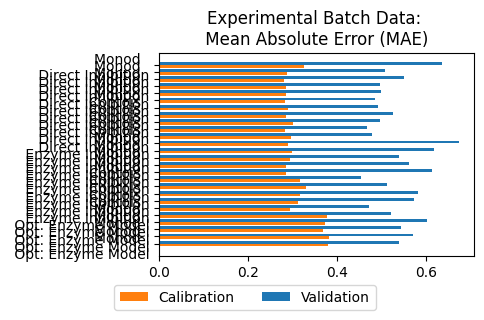

In [8]:
# Plot Results as a bar graph

errorTypes = ['MAE']
fig, ax = plt.subplots(nrows=len(errorTypes), figsize=(5, len(errorTypes) * 3))

results_dict_params = pd.read_csv('params.csv', index_col = False)
results_dict_params_bonus = dict(zip(results_dict_params['key'],results_dict_params['params']))
results_dict_params['key'] = results_dict_params['key'].apply(ast.literal_eval)
results_dict_params['params'] = results_dict_params['params'].apply(ast.literal_eval)

results_dict_values = pd.read_csv('values.csv', index_col = False)
results_dict_values['key'] = results_dict_values['key'].apply(ast.literal_eval)
results_dict_values_bonus = dict(zip(results_dict_values['key'], results_dict_values['Error value']))

for i, errorType in enumerate(errorTypes):
    keys = list(results_dict_values_bonus.keys())
    values = list(results_dict_values_bonus.values())

    calibration_keys = [key for key in keys if key[2] == 'calibration' and key[3] == errorType]
    calibration_values = [results_dict_values_bonus[key] for key in calibration_keys]

    validation_keys = [key for key in keys if key[2] == 'validation' and key[3] == errorType]
    validation_values = [results_dict_values_bonus[key] for key in validation_keys]

    # Merge calibration keys and validation keys
    enzyme_inhibition_name_dict = {False: 'Direct Inhibition', True: 'Enzyme Inhibition', 'Kompala': 'Opt. Enzyme Model'}
    calibration_keys = [str(key[0] + ' ' + " \n " + enzyme_inhibition_name_dict[key[1]]) for key in calibration_keys]
    validation_keys = [str(key[0] + ' ' + " \n " + enzyme_inhibition_name_dict[key[1]]) for key in validation_keys]

    # Reverse the order of bars by reversing both keys and values
    calibration_keys = calibration_keys[::-1]
    calibration_values = calibration_values[::-1]
    validation_keys = validation_keys[::-1]
    validation_values = validation_values[::-1]

    # Plot calibration and validation errors side by side
    bar_width = 0.4
    y_pos = range(len(calibration_keys))
    ax.barh(y_pos, calibration_values, bar_width, label='Calibration', color='tab:orange')
    ax.barh([p + bar_width for p in y_pos], validation_values, bar_width, label='Validation', color='tab:blue')

    ax.set_yticks([p + bar_width / 2 for p in y_pos])
    ax.set_yticklabels(validation_keys)

    if errorType == 'likelihood':
        ax.set_title('Error Type: ' + 'Negative Log Likelihood')
    else:
        ax.set_title('Experimental Batch Data: \n Mean Absolute Error (MAE) ')

# Create a single legend below the last graph
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.075))

plt.tight_layout()
plt.show()

In [46]:
params_df = pd.read_csv('params.csv', index_col = False)
params_df['key'] = params_df['key'].apply(ast.literal_eval)
params_df['params'] = params_df['params'].apply(ast.literal_eval)
results_dict_params = dict(zip(params_df['key'], params_df['params']))

params_df.head(60)

,Unnamed: 0,key,params
0,0,"(Monod, False, calibration, MAE)","{'mu_max1': 0.1069949121458502, 'mu_max2': 0.0..."
1,1,"(Monod, False, validation, MAE)",{'X0': 0.047406896978159994}
2,2,"(Monod, False, calibration, MAE, 0)","{'mu_max1': 0.10054141661993193, 'mu_max2': 0...."
3,3,"(Monod, False, validation, MAE, 0)",{'X0': 0.04294581706100441}
4,4,"(Monod, False, calibration, MAE, 1)","{'mu_max1': 0.10268327506871379, 'mu_max2': 0...."
5,5,"(Monod, False, validation, MAE, 1)",{'X0': 0.040302633682071154}
6,6,"(Monod, False, calibration, MAE, 2)","{'mu_max1': 0.10300243321880732, 'mu_max2': 0...."
7,7,"(Monod, False, validation, MAE, 2)",{'X0': 0.03818700677081876}
8,8,"(Monod, False, calibration, MAE, 3)","{'mu_max1': 0.10113908594905341, 'mu_max2': 0...."
9,9,"(Monod, False, validation, MAE, 3)",{'X0': 0.0398753674531489}


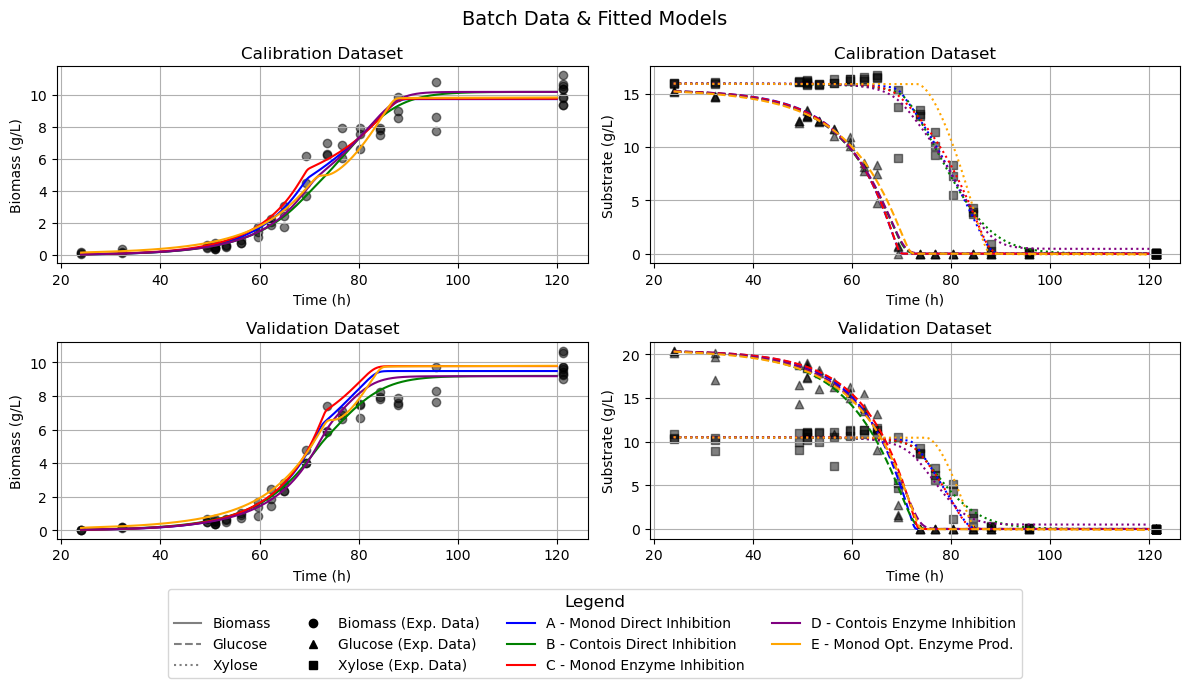

In [ ]:
fitType = 'validation'
errorType = 'MAE'
    
enzyme_inhibition_name_dict = {False:'Direct Inhibition', True: 'Enzyme Inhibition', 'Kompala': 'Opt. Enzyme Prod.'}

# Define colors for each model type
model_colors = {
    ('Monod', False): 'blue',
    ('Contois', False): 'green',
    ('Monod', True): 'red',
    ('Contois', True): 'purple',
    ('Monod', 'Kompala'): 'orange'
}

# Define line styles for different variables
line_styles = {
    'X': '-',
    'S1': '--',
    'S2': ':'
}

# Create figure with two subplots
fig, ([ax1,ax2], [ax3,ax4]) = plt.subplots(2, 2, figsize=(12, 6))
for fitType in ['calibration', 'validation']:
    # Plot experimental data points in both subplots
    if fitType == 'calibration':
            ax1.scatter(exp_data["Time (h)"], exp_data["[Biomass] (g/L)"], color='black', marker='o', alpha=0.5)
            ax2.scatter(exp_data["Time (h)"], exp_data["[Glucose] (g/L)"], color='black', marker='^', label='Glucose Data', alpha=0.5)
            ax2.scatter(exp_data["Time (h)"], exp_data["[Xylose] (g/L)"], color='black', marker='s', label='Xylose Data', alpha=0.5)
    elif fitType == 'validation':
            ax3.scatter(exp_data_2["Time (h)"], exp_data_2["[Biomass] (g/L)"], color='black', marker='o', alpha=0.5)
            ax4.scatter(exp_data_2["Time (h)"], exp_data_2["[Glucose] (g/L)"], color='black', marker='^', label='Glucose Data', alpha=0.5)
            ax4.scatter(exp_data_2["Time (h)"], exp_data_2["[Xylose] (g/L)"], color='black', marker='s', label='Xylose Data', alpha=0.5)
    i=0
    # Plot model predictions
    for enzyme_induction in [False, True, 'Kompala']:
        for growth_model in ['Monod', 'Contois']:
            if growth_model == 'Contois' and enzyme_induction == 'Kompala':
                continue
            i+=1
            params = results_dict_params[(growth_model, enzyme_induction, 'calibration', errorType)]
            val_params = results_dict_params[(growth_model, enzyme_induction, fitType, errorType)]
            params = {**params, **val_params}
            params['enzyme_induction'] = enzyme_induction
            params['growth_model'] = growth_model
            params['dilutionRate'] = 0
            params['n_feeds'] = 1
            params['n_substrates'] = 2
            
            if fitType == 'validation':
                params['S1'] = exp_data_2[exp_data_2['Time (h)'] == 24]['[Glucose] (g/L)'].mean()
                params['S2'] = exp_data_2[exp_data_2['Time (h)'] == 24]['[Xylose] (g/L)'].mean()
            else:
                params['S1'] = exp_data[exp_data['Time (h)'] == 24]['[Glucose] (g/L)'].mean()
                params['S2'] = exp_data[exp_data['Time (h)'] == 24]['[Xylose] (g/L)'].mean()
                
            params['y0'] = 0
            params['S_in1'] = params['S1']
            params['S_in2'] = params['S2']

            # Generate model predictions
            t = np.linspace(24, 120, 1000)
            if params['enzyme_induction'] == True:
                X, S1, S2, Z, y = get_traj(params, t)
            elif params['enzyme_induction'] == False:
                X, S1, S2, y = get_traj(params, t)
            elif params['enzyme_induction'] == 'Kompala':
                X, S1, S2, Z1, Z2, y = get_traj(params, t)

            color = model_colors[(growth_model, enzyme_induction)]
            label = f"{chr(ord('@')+i)} {'-'} {growth_model} {enzyme_inhibition_name_dict[enzyme_induction]}"
            
            # Plot biomass with solid line
            if fitType == 'calibration':
                ax1.plot(t, X, label=label, color=color, linestyle=line_styles['X'])
                
                # Plot substrates with different line styles
                ax2.plot(t, S1, label=f"{label}", color=color, linestyle=line_styles['S1'])
                ax2.plot(t, S2, color=color, linestyle=line_styles['S2'])
            elif fitType == 'validation':
                ax3.plot(t, X, label=label, color=color, linestyle=line_styles['X'])
                
                # Plot substrates with different line styles
                ax4.plot(t, S1, label=f"{label}", color=color, linestyle=line_styles['S1'])
                ax4.plot(t, S2, color=color, linestyle=line_styles['S2'])


# Customize plots
ax1.set_xlabel('Time (h)')
ax3.set_xlabel('Time (h)')
ax1.set_ylabel('Biomass (g/L)')
ax3.set_ylabel('Biomass (g/L)')
ax1.grid(True)
ax3.grid(True)
ax1.set_title("Calibration Dataset")
ax2.set_title("Calibration Dataset")

ax3.set_title("Validation Dataset")
ax4.set_title("Validation Dataset")

fig.suptitle("Batch Data & Fitted Models", fontsize =14)


ax1_lines = ax1.get_legend_handles_labels()[0]
ax1_labels = ax1.get_legend_handles_labels()[1]

ax2.set_xlabel('Time (h)')
ax4.set_xlabel('Time (h)')
ax2.set_ylabel('Substrate (g/L)')
ax2.grid(True)
ax4.set_ylabel('Substrate (g/L)')
ax4.grid(True)
# Add legend with line style and marker explanation
lines = [plt.Line2D([0], [0], color='gray', linestyle=ls) for ls in line_styles.values()]
markers = [plt.Line2D([0], [0], color='black', marker=m, linestyle='') for m in ['o', '^', 's']]
labels = ['Biomass', 'Glucose', 'Xylose', 'Biomass (Exp. Data)', 'Glucose (Exp. Data)', 'Xylose (Exp. Data)']

# Add legend at the bottom center of the figure with 3 columns
fig.legend(lines + markers + ax1_lines, labels + ax1_labels, 
          bbox_to_anchor=(0.5, +0.025),  # Move to bottom center
          loc='upper center', 
          ncol=4,  # 3 columns for better spacing
          title='Legend',
          title_fontsize=12)

plt.tight_layout()
plt.show()


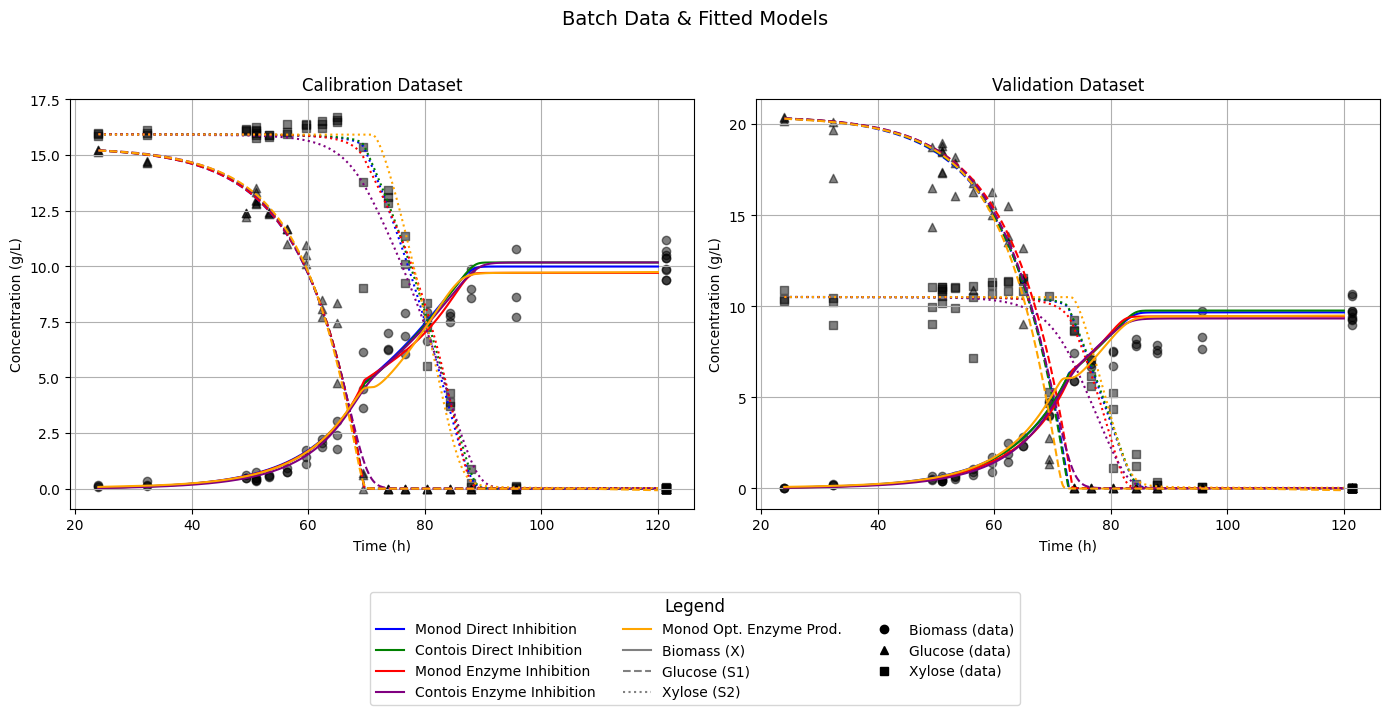

In [55]:
import matplotlib.pyplot as plt
import numpy as np

fitType = 'validation'
errorType = 'MAE'
enzyme_inhibition_name_dict = {False:'Direct Inhibition', True: 'Enzyme Inhibition', 'Kompala': 'Opt. Enzyme Prod.'}

# Define colors for each model type
model_colors = {
    ('Monod', False): 'blue',
    ('Contois', False): 'green',
    ('Monod', True): 'red',
    ('Contois', True): 'purple',
    ('Monod', 'Kompala'): 'orange'
}

# Define line styles for different variables
line_styles = {
    'X': '-',
    'S1': '--',
    'S2': ':'
}

# Create figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

for fitType in ['calibration', 'validation']:
    ax = ax1 if fitType == 'calibration' else ax2
    
    # Plot experimental data
    if fitType == 'calibration':
        ax.scatter(exp_data["Time (h)"], exp_data["[Biomass] (g/L)"], color='black', marker='o', alpha=0.5, label='Biomass (data)')
        ax.scatter(exp_data["Time (h)"], exp_data["[Glucose] (g/L)"], color='black', marker='^', alpha=0.5, label='Glucose (data)')
        ax.scatter(exp_data["Time (h)"], exp_data["[Xylose] (g/L)"], color='black', marker='s', alpha=0.5, label='Xylose (data)')
    else:
        ax.scatter(exp_data_2["Time (h)"], exp_data_2["[Biomass] (g/L)"], color='black', marker='o', alpha=0.5, label='Biomass (data)')
        ax.scatter(exp_data_2["Time (h)"], exp_data_2["[Glucose] (g/L)"], color='black', marker='^', alpha=0.5, label='Glucose (data)')
        ax.scatter(exp_data_2["Time (h)"], exp_data_2["[Xylose] (g/L)"], color='black', marker='s', alpha=0.5, label='Xylose (data)')

    i = 0
    for enzyme_induction in [False, True, 'Kompala']:
        for growth_model in ['Monod', 'Contois']:
            if growth_model == 'Contois' and enzyme_induction == 'Kompala':
                continue

            params = results_dict_params[(growth_model, enzyme_induction, 'calibration', errorType, i)]
            val_params = results_dict_params[(growth_model, enzyme_induction, fitType, errorType, i)]
            i += 1
            params = {**params, **val_params}
            params.update({
                'enzyme_induction': enzyme_induction,
                'growth_model': growth_model,
                'dilutionRate': 0,
                'n_feeds': 1,
                'n_substrates': 2
            })

            if fitType == 'validation':
                params['S1'] = exp_data_2[exp_data_2['Time (h)'] == 24]['[Glucose] (g/L)'].mean()
                params['S2'] = exp_data_2[exp_data_2['Time (h)'] == 24]['[Xylose] (g/L)'].mean()
            else:
                params['S1'] = exp_data[exp_data['Time (h)'] == 24]['[Glucose] (g/L)'].mean()
                params['S2'] = exp_data[exp_data['Time (h)'] == 24]['[Xylose] (g/L)'].mean()

            params['y0'] = 0
            params['S_in1'] = params['S1']
            params['S_in2'] = params['S2']

            # Simulate model
            t = np.linspace(24, 120, 1000)
            if enzyme_induction is True:
                X, S1, S2, Z, y = get_traj(params, t)
            elif enzyme_induction is False:
                X, S1, S2, y = get_traj(params, t)
            else:  # 'Kompala'
                X, S1, S2, Z1, Z2, y = get_traj(params, t)

            color = model_colors[(growth_model, enzyme_induction)]
            label = f"{chr(ord('@')+i)} - {growth_model} {enzyme_inhibition_name_dict[enzyme_induction]}"

            ax.plot(t, X, label=f'{label} (X)', color=color, linestyle=line_styles['X'])
            ax.plot(t, S1, label=f'{label} (S1)', color=color, linestyle=line_styles['S1'])
            ax.plot(t, S2, label=f'{label} (S2)', color=color, linestyle=line_styles['S2'])

    # Customize each subplot
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Concentration (g/L)')
    ax.set_title(f"{fitType.capitalize()} Dataset")
    ax.grid(True)

# Common legend
handles, labels = ax1.get_legend_handles_labels()

import matplotlib.lines as mlines

# --- Legend parts ---

# 1. Model colors (color-coded lines)
model_legend = [
    mlines.Line2D([], [], color=color, linestyle='-', label=f'{model} {enzyme_inhibition_name_dict[induction]}')
    for (model, induction), color in model_colors.items()
]

# 2. Experimental data types (marker-only)
data_legend = [
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Biomass (data)'),
    mlines.Line2D([], [], color='black', marker='^', linestyle='None', label='Glucose (data)'),
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', label='Xylose (data)')
]

# 3. Variable line styles
style_legend = [
    mlines.Line2D([], [], color='gray', linestyle='-', label='Biomass (X)'),
    mlines.Line2D([], [], color='gray', linestyle='--', label='Glucose (S1)'),
    mlines.Line2D([], [], color='gray', linestyle=':', label='Xylose (S2)')
]

# Combine all into one list
custom_legend = model_legend  + style_legend + data_legend
# Combine all legend handles
custom_handles = model_legend +  style_legend + data_legend

# Extract labels manually
custom_labels = [handle.get_label() for handle in custom_handles]

# Add the legend with both handles and labels
fig.legend(handles=custom_handles,
           labels=custom_labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           ncol=3,
           title='Legend',
           title_fontsize=12)


fig.suptitle("Batch Data & Fitted Models", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space for legend
plt.show()

In [196]:
for (key, value) in results_dict_params.items():
    print(key, value)

('Monod', False, 'validation', 'MAE') {'X0': 0.02983763584413421, 'enzyme_induction': False, 'growth_model': 'Monod', 'dilutionRate': 0, 'n_feeds': 1, 'n_substrates': 2, 'S1': 20.313666666666666, 'S2': 10.505, 'y0': 0, 'S_in1': 20.313666666666666, 'S_in2': 10.505}
('Contois', False, 'calibration', 'MAE') {'mu_max1': 0.09944340099950515, 'mu_max2': 0.09066231391524464, 'Yx1': 0.2400183120835964, 'Yx2': 0.40692539826378743, 'K_s1': 0.2500921441967354, 'K_s2': 0.9542558096226651, 'K_I': 0.8506124010763186, 'X0': 0.0346203913881066}
('Monod', True, 'calibration', 'MAE') {'mu_max1': 0.10927379388436854, 'mu_max2': 0.18520444830484467, 'Yx1': 0.32497195911604176, 'Yx2': 0.29893502709112757, 'K_s1': 0.2993111658031389, 'K_s2': 0.7642140197737766, 'K_Z_c': 0.14844431406415642, 'K_Z_S': 0.6933826509243112, 'K_Z_d': 0.13698399200275402, 'K_I': 0.7056275726970496, 'X0': 0.03755290426208664, 'Z0': 0.013738154448785117}
('Contois', True, 'calibration', 'MAE') {'mu_max1': 0.10055480799624254, 'mu_ma

In [198]:
#results_dict_values_archive = results_dict_values.copy()
results_dict_params_archive = results_dict_params.copy()

{'n_feeds': 1, 'n_substrates': 2, 'growth_model': 'Monod', 'enzyme_induction': 'Kompala', 'S1': 15, 'S2': 15, 'y0': 0, 'S_in1': 15, 'S_in2': 15, 'X0': 0.14143873813759555, 'mu_max1': 0.19949565235755667, 'mu_max2': 0.12739603382578157, 'Yx1': 0.3155954745982866, 'Yx2': 0.30360405624724307, 'K_s1': 0.28329051181972154, 'K_s2': 0.4461411796304726, 'K_Z_c': 0.20433191038931026, 'K_Z_S': 0.4104507705477389, 'K_Z_d': 0.38086506862440994, 'Z1': 0.7247065023790847, 'Z2': 0.7295369000376299}


/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:113: RuntimeWarning: invalid value encountered in double_scalars
  v1 = growthRate1/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:114: RuntimeWarning: invalid value encountered in double_scalars
  v2 = growthRate2/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:115: RuntimeWarning: invalid value encountered in double_scalars
  u1 = growthRate1 / (growthRate1 + growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:116: RuntimeWarning: invalid value encountered in double_scalars
  u2 = growthRate2 / (growthRate1 + growthRate2)


Optimal dilution rate: 0.045 1/h
Maximum production rate: 0.378 g/L/h


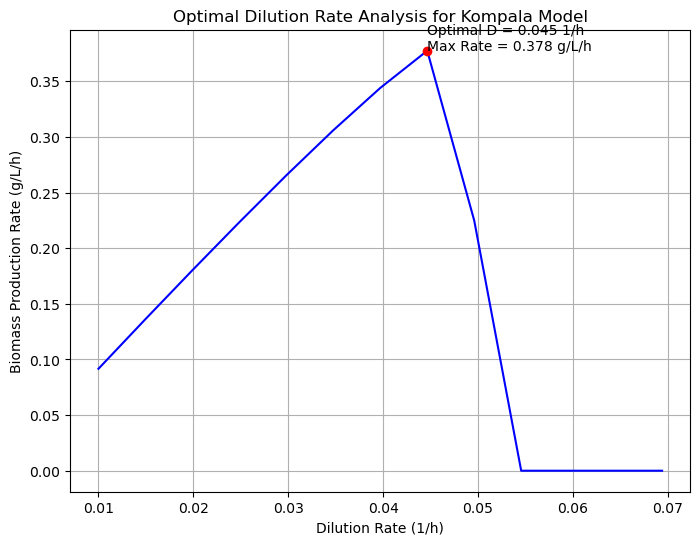

In [215]:
# Determining the optimal dilution rate for the Kompala growth model with the parameters as previously determined by the calibration dataset
# Plot optimal dilution rate vs production rate analysis for each model type
import matplotlib.pyplot as plt

# Model Type
n_substrates = 2
n_feeds = 1

# Inlet/Initial Conditions
y0 = 0
S_in1, S_in2 = 15, 15  # Feed substrate concentrations 
S1, S2 = S_in1, S_in2  # Initial substrate concentrations

# Define parameters for simulation
timestep = 0.1  # Hours
duration = 500  # Hours to reach steady state
totalSteps = int(np.ceil(duration/timestep))
times = np.linspace(0,duration,totalSteps)

# Test range of dilution rates
dilution_rates = np.linspace(0.01, 0.5, 100)
production_rates = np.zeros_like(dilution_rates)

# Get model parameters from calibration results
growth_model = 'Monod'
enzyme_induction = 'Kompala'
fitType = 'calibration'
errorType = 'MAE'
params = results_dict_params_archive[growth_model, enzyme_induction, fitType, errorType].copy()

# Setup base parameters
base_params = {
    'n_feeds': n_feeds, 
    'n_substrates': n_substrates,
    'growth_model': growth_model,
    'enzyme_induction': enzyme_induction,
    'S1': S1, 
    'S2': S2,
    'y0': y0,
    'S_in1': S_in1,
    'S_in2': S_in2,
    'X0': 0.03,  # Start with small biomass
}

# Merge parameters
params = {**base_params, **params}
print(params)

# Calculate steady state production rate for each dilution rate
for i, D in enumerate(dilution_rates):
    params['dilutionRate'] = D
    state0 = [params["X0"], params["S1"], params["S2"], params["Z1"], params["Z2"], params["y0"]]
    yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
    X = yobs[:, 0]
    production_rate = X[-1] * D  # Steady state biomass * dilution rate
    production_rates[i] = production_rate

# Plot results
plt.figure(figsize=(8,6))
plt.plot(dilution_rates, production_rates, 'b-', marker='o')
plt.xlabel('Dilution Rate (1/h)')
plt.ylabel('Biomass Production Rate (g/L/h)')
plt.title('Optimal Dilution Rate Analysis for Kompala Model')
plt.grid(True)

# Find and mark optimal point
optimal_idx = np.nanargmax(production_rates)
optimal_D = dilution_rates[optimal_idx]
optimal_rate = production_rates[optimal_idx]

plt.plot(optimal_D, optimal_rate, 'ro')
plt.annotate(f'Optimal D = {optimal_D:.3f} 1/h\nMax Rate = {optimal_rate:.3f} g/L/h', 
             xy=(optimal_D, optimal_rate), 
             xytext=(0, 0),
             textcoords='offset points')

print(f'Optimal dilution rate: {optimal_D:.3f} 1/h')
print(f'Maximum production rate: {optimal_rate:.3f} g/L/h')

In [219]:
# Empirically determine production rates
# Model Type
n_feeds, n_substrates = 1, 2

# Inlet/Initial Conditions
y0 = 0
S_in1, S_in2 = 15, 15  # Feed substrate concentrations 
S1, S2 = S_in1, S_in2  # Initial substrate concentrations

# Define parameters for simulation
timestep = 0.1  # Hours
duration = 500  # Hours to reach steady state
totalSteps = int(np.ceil(duration/timestep))
times = np.linspace(0,duration,totalSteps)

# Test range of dilution rates
dilution_rates = np.linspace(0.01, 0.2, 100)
production_rates = {}
optimal_dilution_rates = {}

# Get model parameters from calibration results
fitType = 'calibration'
errorType = 'MAE'

for enzyme_induction in [False, True, 'Kompala']:
    for growth_model in ['Monod', 'Contois']:
        if enzyme_induction == 'Kompala' and growth_model == 'Contois':
            continue
            
        print(f'Testing {growth_model} model with {enzyme_induction} enzyme induction')
        
        # Setup base parameters
        base_params = {
            'n_feeds': n_feeds, 
            'n_substrates': n_substrates,
            'growth_model': growth_model,
            'enzyme_induction': enzyme_induction,
            'S1': S1, 
            'S2': S2,
            'y0': y0,
            'S_in1': S_in1,
            'S_in2': S_in2,
            'X0': 10  # Start with small biomass
        }
        
        # Get calibrated parameters
        opt_param_dict = results_dict_params_archive[(growth_model, enzyme_induction, fitType, errorType)]
        params = {**base_params, **opt_param_dict}
        
        prod_rate_list = []
        
        # Test each dilution rate
        for D in dilution_rates:
            params['dilutionRate'] = D
            
            # Initialize state variables based on model type
            if enzyme_induction == False:
                state0 = [params["X0"], params["S1"], params["S2"], params["y0"]]
            elif enzyme_induction == True:
                state0 = [params["X0"], params["S1"], params["S2"], params["Z0"], params["y0"]]
            elif enzyme_induction == 'Kompala':
                state0 = [params["X0"], params["S1"], params["S2"], params["Z1"], params["Z2"], params["y0"]]
                
            # Simulate to steady state
            yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
            X = yobs[:, 0]
            
            # Calculate production rate
            prod_rate = X[-1] * D  # Steady state biomass * dilution rate
            prod_rate_list.append(prod_rate)
            
        # Store results
        production_rates[(growth_model, enzyme_induction)] = np.nanmax(prod_rate_list)
        optimal_idx = np.nanargmax(prod_rate_list)
        optimal_dilution_rates[(growth_model, enzyme_induction)] = dilution_rates[optimal_idx]
        print(f'Optimal dilution rate: {dilution_rates[optimal_idx]:.3f} 1/h')
        print(f'Maximum production rate: {prod_rate_list[optimal_idx]:.3f} g/L/h\n')
        print(production_rates[(growth_model, enzyme_induction)])

Testing Monod model with False enzyme induction
Optimal dilution rate: 0.071 1/h
Maximum production rate: 0.524 g/L/h

0.5238856723896848
Testing Contois model with False enzyme induction
Optimal dilution rate: 0.068 1/h
Maximum production rate: 0.380 g/L/h

0.3799835189732863
Testing Monod model with True enzyme induction
Optimal dilution rate: 0.096 1/h
Maximum production rate: 0.833 g/L/h

0.8330972483207483
Testing Contois model with True enzyme induction
Optimal dilution rate: 0.091 1/h
Maximum production rate: 0.628 g/L/h

0.6276056188939838
Testing Monod model with Kompala enzyme induction


/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:113: RuntimeWarning: invalid value encountered in double_scalars
  v1 = growthRate1/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:114: RuntimeWarning: invalid value encountered in double_scalars
  v2 = growthRate2/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:115: RuntimeWarning: invalid value encountered in double_scalars
  u1 = growthRate1 / (growthRate1 + growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_80148/3341384214.py:116: RuntimeWarning: invalid value encountered in double_scalars
  u2 = growthRate2 / (growthRate1 + growthRate2)


Optimal dilution rate: 0.046 1/h
Maximum production rate: 0.388 g/L/h

0.3876736455951767


In [246]:
# Constant Dilution Rate, Two Feed, Dual Substrate Simulation, Contois Growth Model
# System Parameters and Initial Conditions

n_substrates = 2
n_feeds = 1

fitType = 'calibration'
errorType = 'MAE'

S_in1, S_in2 = 15, 15
S1, S2 = S_in1, S_in2
y0 = 0

params = {'n_feeds': n_feeds, 'n_substrates': n_substrates, 'S1': S1, 'S2':S2, 'y0':y0, 'S_in1':S_in1, 'S_in2':S_in2}

# Time-keeping
timestep = 0.1 # Unit: hours
duration = 500 # Unit: hours
totalSteps = int(np.ceil(duration/timestep))
times = np.linspace(0,duration,totalSteps) # Start, stop, samples in hours

xylose_efficiency_dict = {}
glucose_efficiency_dict = {}
prod_rate_dict = {}

name_change_dict = {True: 'Enzyme Inhibition', False: 'Direct Inhibition', 'Kompala': 'Optimal \n Enzyme Production'}

for enzyme_induction in [True, False, 'Kompala']:
    for growth_model in ['Monod', 'Contois']:

        if enzyme_induction == 'Kompala' and growth_model == 'Contois':
            continue
        
        print('Enzyme Induction: ', enzyme_induction, 'Growth Model: ', growth_model)
        dilutionRate = optimal_dilution_rates[growth_model, enzyme_induction]
        print("Optimal Dilution Rate: ", dilutionRate)
        params['dilutionRate'] = dilutionRate
        params['enzyme_induction'] = enzyme_induction
        params['growth_model'] = growth_model
        opt_param_dict = results_dict_params_archive[growth_model, enzyme_induction, fitType, errorType]
        params['mu_max1'], params['mu_max2'] = opt_param_dict['mu_max1'], opt_param_dict['mu_max2']
        params['K_s1'], params['K_s2'] = opt_param_dict['K_s1'], opt_param_dict['K_s2']
        params['Yx1'], params['Yx2'] = opt_param_dict['Yx1'], opt_param_dict['Yx2']

        # We want a fair comparison, so we will use the same initial conditions for each simulation
        params['X0'] = 0.03

        if enzyme_induction == True:
            params['Z0'] = opt_param_dict['Z0']
            params['K_Z_c'] = opt_param_dict['K_Z_c']
            params['K_Z_S'] = opt_param_dict['K_Z_S']
            params['K_Z_d'] = 0
        elif enzyme_induction == False:
            params['K_I'] = opt_param_dict['K_I']
        elif enzyme_induction == 'Kompala':
            params['Z1'], params['Z2'] = opt_param_dict['Z1'], opt_param_dict['Z2']

        #print("Total dilution rate", dilutionRate, "S1-Inlet Concentration: ", params["S_in1"], "S2-Inlet Concentration: ", params["S_in2"])

        if enzyme_induction == False:
            state0 = [params["X0"], params["S1"], params["S2"], params["y0"]]
        elif enzyme_induction == True:
            state0 = [params["X0"], params["S1"], params["S2"], params["Z0"], params["y0"]]
        elif enzyme_induction == 'Kompala':
            state0 = [params["X0"], params["S1"], params["S2"], params["Z1"], params["Z2"], params["y0"]]
        else:
            raise ValueError("Enzyme induction should be a Boolean or 'Kompala'")

        yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))

        X, S1, S2, y = yobs[:,0], yobs[:,1], yobs[:,2], yobs[:,-1]
        u1 = np.ones(len(times)) * dilutionRate
        u2 = np.ones(len(times)) * dilutionRate
        u = np.vstack((u1,u2)).T
        S = np.vstack((S1,S2)).T
        #fig = plot_results(times, X, S, u, title = f"Enzyme Induction: {enzyme_induction}, Growth Model: {growth_model}")
        print("Production rate: ", X[-1]*dilutionRate)
        #print("Substrate Use Efficiency (%):", 100*(1-S1[-1]/S1[0]), 100*(1-S2[-1]/S2[0]))
        #print("Yx1: ", params['Yx1'], "Yx2: ", params['Yx2'])
        enzyme_model_name = name_change_dict[enzyme_induction]

        glucose_efficiency_dict[enzyme_model_name, growth_model] = (1-S1[-1]/S1[0])*params['Yx1']
        xylose_efficiency_dict[enzyme_model_name, growth_model] = (1-S2[-1]/S2[0])*params['Yx2']
        prod_rate_dict[enzyme_model_name, growth_model] = X[-1]*dilutionRate
        print()

Enzyme Induction:  True Growth Model:  Monod
Optimal Dilution Rate:  0.09636363636363636
Production rate:  0.8690037777648632

Enzyme Induction:  True Growth Model:  Contois
Optimal Dilution Rate:  0.0906060606060606
Production rate:  0.7730710817107941

Enzyme Induction:  False Growth Model:  Monod
Optimal Dilution Rate:  0.07141414141414142
Production rate:  0.5238856685130102

Enzyme Induction:  False Growth Model:  Contois
Optimal Dilution Rate:  0.06757575757575758
Production rate:  0.3799835188043496

Enzyme Induction:  Kompala Growth Model:  Monod
Optimal Dilution Rate:  0.046464646464646465
Production rate:  0.4310112368466551



In [251]:
print(xylose_efficiency_dict)
print(glucose_efficiency_dict)
print(prod_rate_dict)

{('Enzyme Inhibition', 'Monod'): 0.2819369521860667, ('Enzyme Inhibition', 'Contois'): 0.34523290473661616, ('Direct Inhibition', 'Monod'): 0.19525224875599406, ('Direct Inhibition', 'Contois'): 0.15030281148116711, ('Optimal \n Enzyme Production', 'Monod'): 0.3030825254736378}
{('Enzyme Inhibition', 'Monod'): 0.3192606299154111, ('Enzyme Inhibition', 'Contois'): 0.22358193799373405, ('Direct Inhibition', 'Monod'): 0.29380650827170995, ('Direct Inhibition', 'Contois'): 0.22456882141998485, ('Optimal \n Enzyme Production', 'Monod'): 0.3153249013061752}
{('Enzyme Inhibition', 'Monod'): 0.8690037777648632, ('Enzyme Inhibition', 'Contois'): 0.7730710817107941, ('Direct Inhibition', 'Monod'): 0.5238856685130102, ('Direct Inhibition', 'Contois'): 0.3799835188043496, ('Optimal \n Enzyme Production', 'Monod'): 0.4310112368466551}


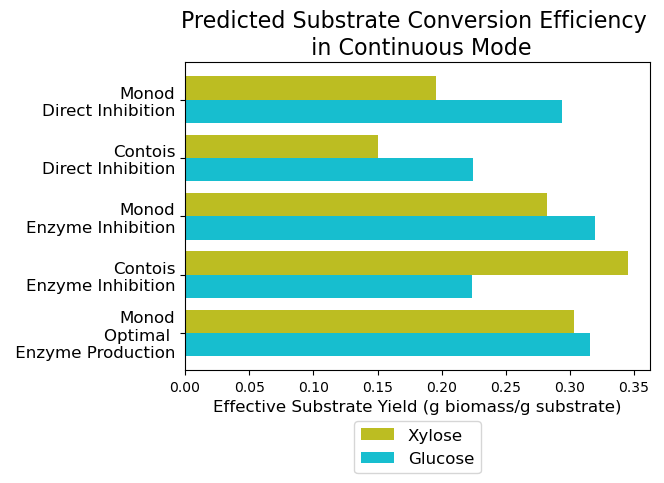

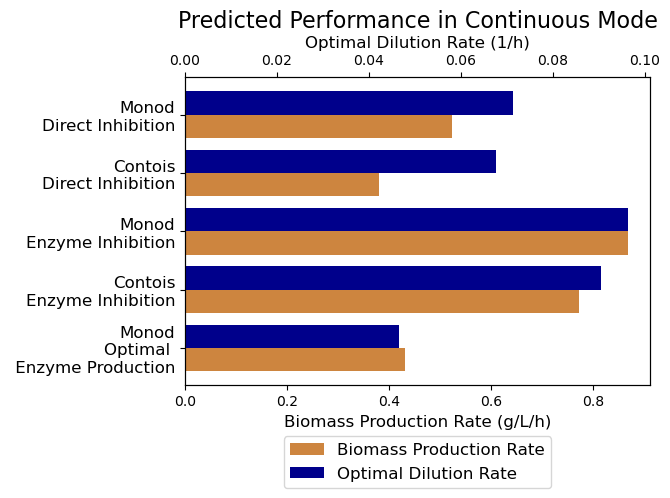

In [279]:
SUE_continuous_glucose_list = list(glucose_efficiency_dict.values())
SUE_continuous_xylose_list = list(xylose_efficiency_dict.values())
prod_continuous_list = list(prod_rate_dict.values())
model_names = [f"{key[1]}\n{key[0]}" for key in glucose_efficiency_dict.keys()]

# Create new order: Direct Inhibition, then Enzyme Inhibition, then Optimal Enzyme Production
desired_order = [
    'Monod\nOptimal \n Enzyme Production',
    'Contois\nEnzyme Inhibition',
    'Monod\nEnzyme Inhibition',
    'Contois\nDirect Inhibition',
    'Monod\nDirect Inhibition',
]

# Reorder all lists based on the desired order
def reorder_list(lst, current_names, desired_names):
    return [lst[current_names.index(name)] for name in desired_names]

SUE_continuous_glucose_list = reorder_list(SUE_continuous_glucose_list, model_names, desired_order)
SUE_continuous_xylose_list = reorder_list(SUE_continuous_xylose_list, model_names, desired_order)
prod_continuous_list = reorder_list(prod_continuous_list, model_names, desired_order)
model_names = desired_order

fontsize1 = 16
fontsize2 = 12

X_axis = np.arange(len(model_names))

# First plot
plt.figure(figsize=(6,4))
plt.barh(X_axis - 0.2, SUE_continuous_glucose_list, 0.4, label = 'Glucose', color = 'tab:cyan')
plt.barh(X_axis + 0.2, SUE_continuous_xylose_list, 0.4, label = 'Xylose', color = 'tab:olive')
plt.yticks(X_axis, model_names, fontsize = fontsize2)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize = fontsize2, bbox_to_anchor=(.5, -0.25), loc='center')
plt.xlabel('Effective Substrate Yield (g biomass/g substrate)', fontsize = fontsize2)
plt.title('Predicted Substrate Conversion Efficiency \n in Continuous Mode', fontsize = fontsize1)

# Second plot
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot biomass production rate on primary axis
ax1.barh(X_axis - 0.2, prod_continuous_list, 0.4, color='peru', label='Biomass Production Rate')
ax1.set_xlabel('Biomass Production Rate (g/L/h)', fontsize=fontsize2)
ax1.tick_params(axis='y', labelsize=fontsize2)
ax1.set_xlim(left=0)  # Set x-axis origin at 0

# Create second axis for optimal dilution rates 
ax2 = ax1.twiny()
ax2.barh(X_axis + 0.2, optimal_rates, 0.4, color='darkblue', label='Optimal Dilution Rate')
ax2.set_xlabel('Optimal Dilution Rate (1/h)', fontsize=fontsize2) 
ax2.set_xlim(left=0)  # Set second x-axis origin at 0

# Set y-axis labels and title
ax1.set_yticks(X_axis)
ax1.set_yticklabels(model_names, fontsize=fontsize2)
plt.title('Predicted Performance in Continuous Mode', fontsize=fontsize1)

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=fontsize2, bbox_to_anchor=(.5, -0.25), loc='center')


In [51]:
results_dict_params[growth_model, enzyme_induction, 'calibration', 'likelihood']['mu_max1']

0.10617101023724163

In [292]:
print(results_dict_values_archive.keys())
print(results_dict_params_archive[growth_model, enzyme_induction, 'calibration'])

dict_keys([('Monod', True, 'calibration'), ('Monod', True, 'validation'), ('Contois', True, 'calibration'), ('Contois', True, 'validation'), ('Monod', False, 'calibration'), ('Monod', False, 'validation'), ('Contois', False, 'calibration'), ('Contois', False, 'validation'), ('Monod', 'Kompala', 'calibration'), ('Monod', 'Kompala', 'validation')])
{'mu_max1': 0.11180075381193535, 'mu_max2': 0.06205677069018734, 'Yx1': 0.27460213300345865, 'Yx2': 0.3549684928784765, 'K_s1': 0.5750261410894658, 'K_s2': 0.6144169832158791, 'K_Z_c': 0.876054817740342, 'K_Z_S': 0.8516221490841891, 'K_I': 0.41659423216351765, 'Z0': 0.01, 'X0': 0.030397893113131343}


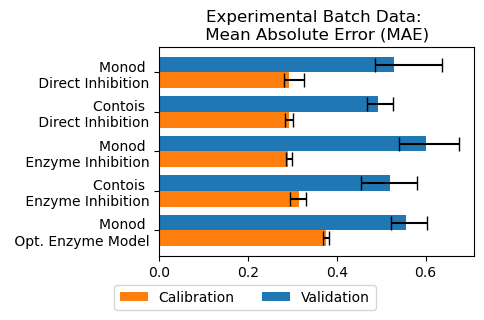

In [91]:
# Plot Results as a bar graph

errorTypes = ['MAE']
fig, ax = plt.subplots(nrows=len(errorTypes), figsize=(5, len(errorTypes) * 3))

for i, errorType in enumerate(errorTypes):
    keys = list(results_dict_values.keys())
    values = list(results_dict_values.values())

    calibration_keys = [key for key in keys if key[2] == 'calibration' and key[3] == errorType]
    validation_keys = [key for key in keys if key[2] == 'validation' and key[3] == errorType]

    # Group by growth model and enzyme induction
    grouped_calibration = {}
    grouped_validation = {}

    for key in calibration_keys:
        model_key = (key[0], key[1])
        if model_key not in grouped_calibration:
            grouped_calibration[model_key] = []
        grouped_calibration[model_key].append(results_dict_values[key])

    for key in validation_keys:
        model_key = (key[0], key[1])
        if model_key not in grouped_validation:
            grouped_validation[model_key] = []
        grouped_validation[model_key].append(results_dict_values[key])

    # Calculate mean, min, and max for each group
    calibration_stats = {k: (np.mean(v), np.min(v), np.max(v)) for k, v in grouped_calibration.items()}
    validation_stats = {k: (np.mean(v), np.min(v), np.max(v)) for k, v in grouped_validation.items()}

    # Prepare data for plotting
    enzyme_inhibition_name_dict = {False: 'Direct Inhibition', True: 'Enzyme Inhibition', 'Kompala': 'Opt. Enzyme Model'}
    calibration_labels = [f"{key[0]} \n {enzyme_inhibition_name_dict[key[1]]}" for key in calibration_stats.keys()]
    validation_labels = [f"{key[0]} \n {enzyme_inhibition_name_dict[key[1]]}" for key in validation_stats.keys()]

    calibration_means = [calibration_stats[key][0] for key in calibration_stats.keys()]
    validation_means = [validation_stats[key][0] for key in validation_stats.keys()]

    calibration_errors = [(calibration_stats[key][0] - calibration_stats[key][1], calibration_stats[key][2] - calibration_stats[key][0]) for key in calibration_stats.keys()]
    validation_errors = [(validation_stats[key][0] - validation_stats[key][1], validation_stats[key][2] - validation_stats[key][0]) for key in validation_stats.keys()]

    # Reverse the order of bars by reversing both keys and values
    calibration_labels = calibration_labels[::-1]
    calibration_means = calibration_means[::-1]
    calibration_errors = calibration_errors[::-1]
    validation_labels = validation_labels[::-1]
    validation_means = validation_means[::-1]
    validation_errors = validation_errors[::-1]

    # Plot calibration and validation errors side by side
    bar_width = 0.4
    y_pos = range(len(calibration_labels))
    ax.barh(y_pos, calibration_means, bar_width, label='Calibration', color='tab:orange', xerr=np.array(calibration_errors).T, capsize=5)
    ax.barh([p + bar_width for p in y_pos], validation_means, bar_width, label='Validation', color='tab:blue', xerr=np.array(validation_errors).T, capsize=5)

    ax.set_yticks([p + bar_width / 2 for p in y_pos])
    ax.set_yticklabels(validation_labels)

    if errorType == 'likelihood':
        ax.set_title('Error Type: ' + 'Negative Log Likelihood')
    else:
        ax.set_title('Experimental Batch Data: \n Mean Absolute Error (MAE) ')

# Create a single legend below the last graph
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.075))

plt.tight_layout()
plt.show()

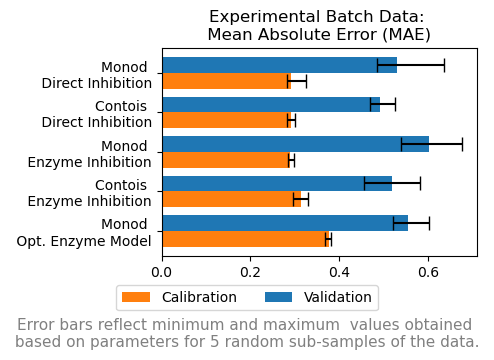

In [176]:
# Plot Results as a bar graph

results_dict_params = pd.read_csv('params.csv', index_col = False)
results_dict_params['key'] = results_dict_params['key'].apply(ast.literal_eval)
results_dict_params['params'] = results_dict_params['params'].apply(ast.literal_eval)
results_dict_params = dict(zip(results_dict_params['key'],results_dict_params['params']))

results_dict_values = pd.read_csv('values.csv', index_col = False)
results_dict_values['key'] = results_dict_values['key'].apply(ast.literal_eval)
results_dict_values = dict(zip(results_dict_values['key'], results_dict_values['Error value']))

errorTypes = ['MAE']
fig, ax = plt.subplots(nrows=len(errorTypes), figsize=(5, len(errorTypes) * 3))

for i, errorType in enumerate(errorTypes):
    keys = list(results_dict_values.keys())
    values = list(results_dict_values.values())

    calibration_keys = [key for key in keys if key[2] == 'calibration' and key[3] == errorType]
    validation_keys = [key for key in keys if key[2] == 'validation' and key[3] == errorType]

    # Group by growth model and enzyme induction
    grouped_calibration = {}
    grouped_validation = {}

    for key in calibration_keys:
        model_key = (key[0], key[1])
        if model_key not in grouped_calibration:
            grouped_calibration[model_key] = []
        grouped_calibration[model_key].append(results_dict_values[key])

    for key in validation_keys:
        model_key = (key[0], key[1])
        if model_key not in grouped_validation:
            grouped_validation[model_key] = []
        grouped_validation[model_key].append(results_dict_values[key])

    # Calculate mean, min, and max for each group
    calibration_stats = {k: (np.mean(v), np.min(v), np.max(v)) for k, v in grouped_calibration.items()}
    validation_stats = {k: (np.mean(v), np.min(v), np.max(v)) for k, v in grouped_validation.items()}

    # Prepare data for plotting
    enzyme_inhibition_name_dict = {False: 'Direct Inhibition', True: 'Enzyme Inhibition', 'Kompala': 'Opt. Enzyme Model'}
    calibration_labels = [f"{key[0]} \n {enzyme_inhibition_name_dict[key[1]]}" for key in calibration_stats.keys()]
    validation_labels = [f"{key[0]} \n {enzyme_inhibition_name_dict[key[1]]}" for key in validation_stats.keys()]

    calibration_means = [calibration_stats[key][0] for key in calibration_stats.keys()]
    validation_means = [validation_stats[key][0] for key in validation_stats.keys()]

    calibration_errors = [(calibration_stats[key][0] - calibration_stats[key][1], calibration_stats[key][2] - calibration_stats[key][0]) for key in calibration_stats.keys()]
    validation_errors = [(validation_stats[key][0] - validation_stats[key][1], validation_stats[key][2] - validation_stats[key][0]) for key in validation_stats.keys()]

    # Reverse the order of bars by reversing both keys and values
    calibration_labels = calibration_labels[::-1]
    calibration_means = calibration_means[::-1]
    calibration_errors = calibration_errors[::-1]
    validation_labels = validation_labels[::-1]
    validation_means = validation_means[::-1]
    validation_errors = validation_errors[::-1]

    # Plot calibration and validation errors side by side
    bar_width = 0.4
    y_pos = range(len(calibration_labels))
    ax.barh(y_pos, calibration_means, bar_width, label='Calibration', color='tab:orange', xerr=np.array(calibration_errors).T, capsize=5)
    ax.barh([p + bar_width for p in y_pos], validation_means, bar_width, label='Validation', color='tab:blue', xerr=np.array(validation_errors).T, capsize=5)

    ax.set_yticks([p + bar_width / 2 for p in y_pos])
    ax.set_yticklabels(validation_labels)

    if errorType == 'likelihood':
        ax.set_title('Error Type: ' + 'Negative Log Likelihood')
    else:
        ax.set_title('Experimental Batch Data: \n Mean Absolute Error (MAE) ')

# Create a single legend below the last graph
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.075))
fig.text(0.5, -0.13, "Error bars reflect minimum and maximum  values obtained \n based on parameters for 5 random sub-samples of the data. ", 
         ha='center', va='center', fontsize=11, color='gray')
plt.tight_layout()

In [100]:
# Empirically determine production rates
# Model Type
n_feeds, n_substrates = 1, 2

# Inlet/Initial Conditions
y0 = 0
S_in1, S_in2 = 15, 15  # Feed substrate concentrations 
S1, S2 = S_in1, S_in2  # Initial substrate concentrations

# Define parameters for simulation
timestep = 0.1  # Hours
duration = 500  # Hours to reach steady state
totalSteps = int(np.ceil(duration/timestep))
times = np.linspace(0,duration,totalSteps)

# Test range of dilution rates
dilution_rates = np.linspace(0.01, 0.2, 100)
production_rates = {}
optimal_dilution_rates = {}

# Get model parameters from calibration results
fitType = 'calibration'
errorType = 'MAE'

# Separate dictionaries for min, max, and mean production rates
min_production_rates = {}
max_production_rates = {}
mean_production_rates = {}

min_dilution_rates = {}
max_dilution_rates = {}
mean_dilution_rates = {}

min_glucose_efficiencies = {}
max_glucose_efficiencies = {}
mean_glucose_efficiencies = {}

min_xylose_efficiencies = {}
max_xylose_efficiencies = {}
mean_xylose_efficiencies = {}

# Store all values so they can be plotted as points
xylose_efficiency_dict = {}
glucose_efficiency_dict = {}
prod_rate_dict = {}
dilution_rate_dict = {}


for enzyme_induction in [False, True, 'Kompala']:
    for growth_model in ['Monod', 'Contois']:
        if enzyme_induction == 'Kompala' and growth_model == 'Contois':
            continue
            
        print(f'Testing {growth_model} model with {enzyme_induction} enzyme induction')
        
        # Setup base parameters
        base_params = {
            'n_feeds': n_feeds, 
            'n_substrates': n_substrates,
            'growth_model': growth_model,
            'enzyme_induction': enzyme_induction,
            'S1': S1, 
            'S2': S2,
            'y0': y0,
            'S_in1': S_in1,
            'S_in2': S_in2,
            'X0': 10
        }
        
        all_prod_rates = []
        all_dilution_rates = []
        all_glucose_efficiencies = []
        all_xylose_efficiencies = []
        
        for repeat in range(5):  # Assuming 5 repeats
            # Get calibrated parameters
            opt_param_dict = results_dict_params[(growth_model, enzyme_induction, fitType, errorType, repeat)]
            params = {**base_params, **opt_param_dict}
            prod_rate_list = []
            glucose_efficiency_list = []
            xylose_efficiency_list = []
            
            # Test each dilution rate
            for D in dilution_rates:
                params['dilutionRate'] = D
                # Initialize state variables based on model type
                if enzyme_induction == False:
                    state0 = [params["X0"], params["S1"], params["S2"], params["y0"]]
                elif enzyme_induction == True:
                    state0 = [params["X0"], params["S1"], params["S2"], params["Z0"], params["y0"]]
                elif enzyme_induction == 'Kompala':
                    state0 = [params["X0"], params["S1"], params["S2"], params["Z1"], params["Z2"], params["y0"]]
                    
                # Simulate to steady state
                yobs = scipy.integrate.odeint(plantODE, state0, times, args=(params,))
                X = yobs[:, 0]
                
                # Calculate production rate
                prod_rate = X[-1] * D  # Steady state biomass * dilution rate
                prod_rate_list.append(prod_rate)

                # Calculate efficiencies
                glucose_efficiency = (1 - yobs[-1, 1] / S_in1) * params['Yx1']
                xylose_efficiency = (1 - yobs[-1, 2] / S_in2) * params['Yx2']
                glucose_efficiency_list.append(glucose_efficiency)
                xylose_efficiency_list.append(xylose_efficiency)
                
            # Store results for this repeat
            all_prod_rates.append(np.nanmax(prod_rate_list))
            optimal_idx = np.nanargmax(prod_rate_list)
            all_dilution_rates.append(dilution_rates[optimal_idx])
            all_glucose_efficiencies.append(glucose_efficiency_list[optimal_idx])
            all_xylose_efficiencies.append(xylose_efficiency_list[optimal_idx])
            optimal_dilution_rates[(growth_model, enzyme_induction, fitType, repeat)] = dilution_rates[optimal_idx]
            results_dict_params[(growth_model, enzyme_induction, fitType, errorType, repeat)]['optimal_dilution_rate'] = dilution_rates[optimal_idx]
        
        # Calculate min, max, and mean production rates
        min_production_rates[(growth_model, enzyme_induction, fitType)] = np.min(all_prod_rates)
        max_production_rates[(growth_model, enzyme_induction, fitType)] = np.max(all_prod_rates)
        mean_production_rates[(growth_model, enzyme_induction, fitType)] = np.mean(all_prod_rates)

        print(f'Min prod rate: {min_production_rates[(growth_model, enzyme_induction, fitType)]:.3f} g/L/h, '
              f'Max prod rate: {max_production_rates[(growth_model, enzyme_induction, fitType)]:.3f} g/L/h, '
              f'Mean prod rate: {mean_production_rates[(growth_model, enzyme_induction, fitType)]:.3f} g/L/h')

        min_dilution_rates[(growth_model, enzyme_induction, fitType)] = np.min(all_dilution_rates)
        max_dilution_rates[(growth_model, enzyme_induction, fitType)] = np.max(all_dilution_rates)
        mean_dilution_rates[(growth_model, enzyme_induction, fitType)] = np.mean(all_dilution_rates)

        print(f'Min dilution rate: {min_dilution_rates[(growth_model, enzyme_induction, fitType)]:.3f} 1/h, '
              f'Max dilution rate: {max_dilution_rates[(growth_model, enzyme_induction, fitType)]:.3f} 1/h, '
              f'Mean dilution rate: {mean_dilution_rates[(growth_model, enzyme_induction, fitType)]:.3f} 1/h')
        
        min_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.min(all_glucose_efficiencies)
        max_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.max(all_glucose_efficiencies)
        mean_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.mean(all_glucose_efficiencies)

        min_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.min(all_xylose_efficiencies)
        max_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.max(all_xylose_efficiencies)
        mean_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] = np.mean(all_xylose_efficiencies)

        print(f'Min glucose efficiency: {min_glucose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate, '
                f'Max glucose efficiency: {max_glucose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate, '
                f'Mean glucose efficiency: {mean_glucose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate, ')

        print(f'Min xylose efficiency: {min_xylose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate, '
                f'Max xylose efficiency: {max_xylose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate, '
                f'Mean xylose efficiency: {mean_xylose_efficiencies[(growth_model, enzyme_induction, fitType)]:.3f} g biomass/g substrate\n')

Testing Monod model with False enzyme induction
Min prod rate: 0.668 g/L/h, Max prod rate: 0.709 g/L/h, Mean prod rate: 0.687 g/L/h
Min dilution rate: 0.091 1/h, Max dilution rate: 0.093 1/h, Mean dilution rate: 0.091 1/h
Min glucose efficiency: 0.278 g biomass/g substrate, Max glucose efficiency: 0.302 g biomass/g substrate, Mean glucose efficiency: 0.291 g biomass/g substrate, 
Min xylose efficiency: 0.182 g biomass/g substrate, Max xylose efficiency: 0.237 g biomass/g substrate, Mean xylose efficiency: 0.211 g biomass/g substrate

Testing Contois model with False enzyme induction
Min prod rate: 0.426 g/L/h, Max prod rate: 0.693 g/L/h, Mean prod rate: 0.577 g/L/h
Min dilution rate: 0.089 1/h, Max dilution rate: 0.096 1/h, Mean dilution rate: 0.094 1/h
Min glucose efficiency: 0.288 g biomass/g substrate, Max glucose efficiency: 0.297 g biomass/g substrate, Mean glucose efficiency: 0.293 g biomass/g substrate, 
Min xylose efficiency: 0.033 g biomass/g substrate, Max xylose efficiency: 

/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_69224/379565187.py:113: RuntimeWarning: invalid value encountered in double_scalars
  v1 = growthRate1/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_69224/379565187.py:114: RuntimeWarning: invalid value encountered in double_scalars
  v2 = growthRate2/max(growthRate1, growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_69224/379565187.py:115: RuntimeWarning: invalid value encountered in double_scalars
  u1 = growthRate1 / (growthRate1 + growthRate2)
/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_69224/379565187.py:116: RuntimeWarning: invalid value encountered in double_scalars
  u2 = growthRate2 / (growthRate1 + growthRate2)


Min prod rate: 0.317 g/L/h, Max prod rate: 0.350 g/L/h, Mean prod rate: 0.331 g/L/h
Min dilution rate: 0.041 1/h, Max dilution rate: 0.043 1/h, Mean dilution rate: 0.042 1/h
Min glucose efficiency: 0.275 g biomass/g substrate, Max glucose efficiency: 0.314 g biomass/g substrate, Mean glucose efficiency: 0.295 g biomass/g substrate, 
Min xylose efficiency: 0.205 g biomass/g substrate, Max xylose efficiency: 0.272 g biomass/g substrate, Mean xylose efficiency: 0.232 g biomass/g substrate



In [101]:
intra_model_uncertainty_prod = np.max(list(mean_production_rates.values()))-np.min(list(mean_production_rates.values()))
inter_model_uncertainty_prod = np.mean(np.array(list(max_production_rates.values()))-np.array(list(min_production_rates.values())))
mean_prod_rate = np.mean(list(mean_production_rates.values()))
print("Production rate", intra_model_uncertainty_prod/mean_prod_rate, inter_model_uncertainty_prod/mean_prod_rate, intra_model_uncertainty_prod/inter_model_uncertainty_prod)
print()

intra_model_uncertainty_dilution = np.max(list(mean_dilution_rates.values()))-np.min(list(mean_dilution_rates.values()))
inter_model_uncertainty_dilution = np.mean(np.array(list(max_dilution_rates.values()))-np.array(list(min_dilution_rates.values())))
mean_dilution_rate = np.mean(list(mean_dilution_rates.values()))
print("Dilution Rate", intra_model_uncertainty_dilution/mean_dilution_rate, inter_model_uncertainty_dilution/mean_dilution_rate, intra_model_uncertainty_dilution/inter_model_uncertainty_dilution)
print()

inter_model_uncertainty_glucose = np.max(list(mean_glucose_efficiencies.values()))-np.min(list(mean_glucose_efficiencies.values()))
intra_model_uncertainty_glucose = np.mean(np.array(list(max_glucose_efficiencies.values()))-np.array(list(min_glucose_efficiencies.values())))
mean_glucose = np.mean(list(mean_glucose_efficiencies.values()))
print("Glucose Eff", inter_model_uncertainty_glucose/mean_glucose, intra_model_uncertainty_glucose/mean_glucose, inter_model_uncertainty_glucose/intra_model_uncertainty_glucose)
print()

inter_model_uncertainty_xylose = np.max(list(mean_xylose_efficiencies.values()))-np.min(list(mean_xylose_efficiencies.values()))
intra_model_uncertainty_xylose = np.mean(np.array(list(max_xylose_efficiencies.values()))-np.array(list(min_xylose_efficiencies.values())))
mean_xylose = np.mean(list(mean_xylose_efficiencies.values()))
print("Xylose Eff", inter_model_uncertainty_xylose/mean_xylose, intra_model_uncertainty_xylose/mean_xylose, inter_model_uncertainty_xylose/intra_model_uncertainty_xylose)
print()

Production rate 0.7907703045808206 0.24847206747269246 3.182531994940348

Dilution Rate 0.6324588223690699 0.11243712397672358 5.624999999999998

Glucose Eff 0.11181952732511201 0.12233064114776512 0.9140761977209244

Xylose Eff 0.8672242962904866 0.36167965355542553 2.3977690969491845



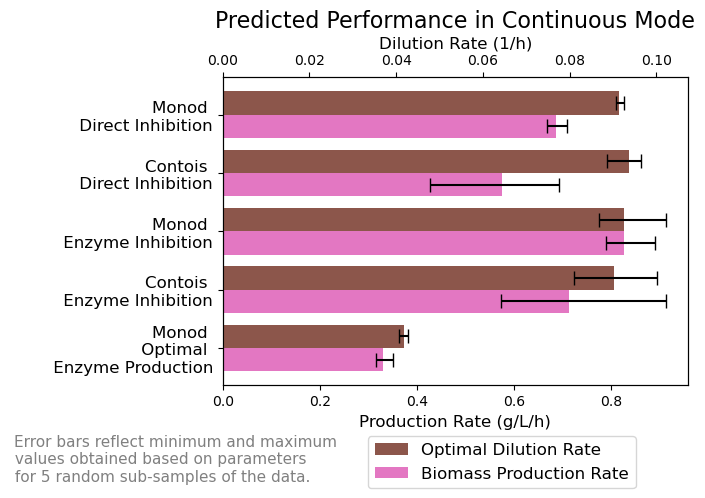

In [178]:
# Plot dilution rates with error bars
name_change_dict = {True: 'Enzyme Inhibition', False: 'Direct Inhibition', 'Kompala': 'Optimal \n Enzyme Production'}
optimal_rates = [mean_dilution_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
min_rates = [min_dilution_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
max_rates = [max_dilution_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
labels = [f"{growth_model} \n {name_change_dict[enzyme_induction]}" for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]

# Calculate error bars for dilution rates
error_bars_dilution = [optimal_rates[i] - min_rates[i] for i in range(len(optimal_rates))], [max_rates[i] - optimal_rates[i] for i in range(len(optimal_rates))]

# Calculate optimal production rates and error bars
optimal_prod_rates = [mean_production_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
min_prod_rates = [min_production_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
max_prod_rates = [max_production_rates[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]

# Calculate error bars for production rates
error_bars_prod = [optimal_prod_rates[i] - min_prod_rates[i] for i in range(len(optimal_prod_rates))], [max_prod_rates[i] - optimal_prod_rates[i] for i in range(len(optimal_prod_rates))]

fontsize1 = 16
fontsize2 = 12

fig, ax1 = plt.subplots(figsize=(6, 4))

# Reverse the order of bars
optimal_prod_rates = optimal_prod_rates[::-1]
error_bars_prod = (error_bars_prod[0][::-1], error_bars_prod[1][::-1])
optimal_rates = optimal_rates[::-1]
error_bars_dilution = (error_bars_dilution[0][::-1], error_bars_dilution[1][::-1])
labels = labels[::-1]

# Plot production rates
bar_width = 0.4
y_pos = np.arange(len(optimal_prod_rates))
ax1.barh(y_pos - bar_width/2, optimal_prod_rates, bar_width, xerr=error_bars_prod, color='tab:pink', capsize=5, label='Biomass Production Rate')
ax1.set_xlabel('Production Rate (g/L/h)', color='k', fontsize=fontsize2)
ax1.tick_params(axis='x', labelcolor='k')

# Create a second y-axis for the dilution rates
ax2 = ax1.twiny()
ax2.barh(y_pos + bar_width/2, optimal_rates, bar_width, xerr=error_bars_dilution, color='tab:brown', capsize=5, label='Optimal Dilution Rate')
ax2.set_xlabel('Dilution Rate (1/h)', color='k', fontsize=fontsize2)
ax2.tick_params(axis='x', labelcolor='k')

# Set y-axis labels and title
ax1.set_yticks(y_pos)
ax1.set_yticklabels(labels, fontsize=fontsize2)
plt.title('Predicted Performance in Continuous Mode', fontsize=fontsize1)

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines2 + lines1, labels2 +labels1, fontsize=fontsize2, bbox_to_anchor=(0.6, -0.25), loc='center')

fig.text(0.05, -0.075, "Error bars reflect minimum and maximum \n values obtained based on parameters        \n for 5 random sub-samples of the data.       ", 
         ha='center', va='center', fontsize=11, color='gray')

plt.show()

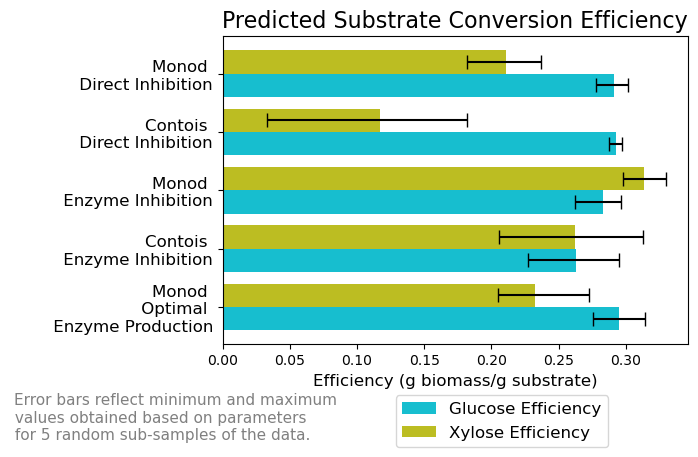

In [161]:
# Plot glucose and xylose efficiencies with error bars
name_change_dict = {True: 'Enzyme Inhibition', False: 'Direct Inhibition', 'Kompala': 'Optimal \n Enzyme Production'}
labels = [f"{growth_model} \n {name_change_dict[enzyme_induction]}" for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]

# Calculate glucose efficiencies and error bars
mean_glucose_eff = [mean_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
min_glucose_eff = [min_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
max_glucose_eff = [max_glucose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
error_bars_glucose = [mean_glucose_eff[i] - min_glucose_eff[i] for i in range(len(mean_glucose_eff))], [max_glucose_eff[i] - mean_glucose_eff[i] for i in range(len(mean_glucose_eff))]

# Calculate xylose efficiencies and error bars
mean_xylose_eff = [mean_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
min_xylose_eff = [min_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
max_xylose_eff = [max_xylose_efficiencies[(growth_model, enzyme_induction, fitType)] for enzyme_induction in [False, True, 'Kompala'] for growth_model in ['Monod', 'Contois'] if not (growth_model == 'Contois' and enzyme_induction == 'Kompala')]
error_bars_xylose = [mean_xylose_eff[i] - min_xylose_eff[i] for i in range(len(mean_xylose_eff))], [max_xylose_eff[i] - mean_xylose_eff[i] for i in range(len(mean_xylose_eff))]

fontsize1 = 16
fontsize2 = 12

fig, ax1 = plt.subplots(figsize=(6, 4))

# Reverse the order of bars
mean_glucose_eff = mean_glucose_eff[::-1]
error_bars_glucose = (error_bars_glucose[0][::-1], error_bars_glucose[1][::-1])
mean_xylose_eff = mean_xylose_eff[::-1]
error_bars_xylose = (error_bars_xylose[0][::-1], error_bars_xylose[1][::-1])
labels = labels[::-1]

# Plot glucose efficiencies
bar_width = 0.4
y_pos = np.arange(len(mean_glucose_eff))
ax1.barh(y_pos - bar_width/2, mean_glucose_eff, bar_width, xerr=error_bars_glucose, color='tab:cyan', capsize=5, label='Glucose Efficiency')
ax1.set_xlabel('Efficiency (g biomass/g substrate)', color='k', fontsize=fontsize2)
ax1.tick_params(axis='x', labelcolor='k')

# Plot xylose efficiencies
ax1.barh(y_pos + bar_width/2, mean_xylose_eff, bar_width, xerr=error_bars_xylose, color='tab:olive', capsize=5, label='Xylose Efficiency')

# Set y-axis labels and title
ax1.set_yticks(y_pos)
ax1.set_yticklabels(labels, fontsize=fontsize2)
plt.title('Predicted Substrate Conversion Efficiency', fontsize=fontsize1)

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=fontsize2, bbox_to_anchor=(.6, -0.25), loc='center')
# ADD NOTE about error bars
fig.text(0.05, -0.075, "Error bars reflect minimum and maximum \n values obtained based on parameters        \n for 5 random sub-samples of the data.       ", 
         ha='center', va='center', fontsize=11, color='gray')
plt.show()
